## Objetivo:

O objetivo desta competição é desenvolver um modelo preditor do ELDT (Estimated Landing Time) para voos comerciais com origem e 
destino nos 12 principais aeródromos do Brasil, a saber:

- Brasília (SBBR)
- Confins (SBCF)
- Curitiba (SBCT)
- Florianópolis (SBFL)
- Rio de Janeiro - Galeão (SBGL)
- Guarulhos (SBGR)
- Campinas (SBKP)
- Porto Alegre (SBPA)
- Recife (SBRF)
- Rio de Janeiro - Santos Dumont (SBRJ)
- São Paulo - Congonhas (SBSP)
- Salvador (SBSV)

In [ ]:
!pip install xgboost
!pip install git+https://github.com/python-metar/python-metar.git
!pip install mlxtend

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE, SelectFromModel

import xgboost as xg


import requests
import random
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from metar import Metar
import re
from sklearn.impute import KNNImputer

random.seed(1)

print(f'tf_version: {tf.__version__}')


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/python-metar/python-metar.git to /tmp/pip-req-build-hhmwvld7
  Running command git clone --filter=blob:none --quiet https://github.com/python-metar/python-metar.git /tmp/pip-req-build-hhmwvld7
  Resolved https://github.com/python-metar/python-metar.git to commit a74df97e61f905617f1707641ddddc5ff236050c
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
tf_version: 2.10.0


## Funções auxiliares

In [ ]:
# Função para carregar os dados da API

def get_data_from_API(base_name, idate, fdate, token='a779d04f85c4bf6cfa586d30aaec57c44e9b7173'):
    ''' base_name (string): nome da base, opcões: bimtra, cat-62, esperas, metaf, metar, satelite, tc-prev, tc-real
        idate (string): data inicial
        fdate (string): data final
        token (string): chave de acesso na API já está defaltada
    ''' 


    url = 'http://montreal.icea.decea.mil.br:5002/api/v1/' + base_name
    params = {
    'token': token,
    'idate': idate,
    'fdate': fdate
}

    headers = {'accept': 'application/json'}

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        base = response.json()
        print(f"Base {base_name} carregada com sucesso!")
        return pd.DataFrame(base)
    else:
        print(f"A solicitação falhou com status code {response.status_code}")

In [ ]:
# Função para transformar datetime em int64

def datetime_to_int64(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S.%f')
    df[column] = (df[column].astype(int) / 10**6) #.astype('datetime64[ms]')
    return df

# Função para transformar int64 em datetime

def int64_to_datetime(data, column=None):
    if column is None:
        # Se 'column' não for especificado, assumimos que 'data' é uma Series
        return data.astype('datetime64[ms]')
    else:
        # Se 'column' for especificado, assumimos que 'data' é um DataFrame
        data[column] = data[column].astype('datetime64[ms]')
        return data

A base de dados BIMTRA possui informações dos movimentos nos aeródromos do Brasil. Assim, é possível encontrar 
dados como hora de decolagem estimada, origem, destino, tempo de voo previsto, etc. Para o problema em questão, 
uma versão resumida do BIMTRA será fornecida, contendo os seguintes campos:

FlightID (Identificador único de um voo)
Origem (Código ICAO do Aeroporto de Origem do voo)
Destino (Código ICAO do Aeroporto de Destino do voo)
Hora_Dep (Data/Hora de Decolagem do voo)
Hora_Arr (Data/Hora de Pouso do voo)

O campo Hora_Arr corresponde ao atributo alvo do desafio proposto, isto é, o modelo desenvolvido por cada equipe 
deverá estimar os valores de Hora_Arr. Tomem cuidado com data leakage, ou seja, construindo modelos com informações do futuro.

In [ ]:
# Setar datas para pegar dados da API
data_inicial = "2022-06-01"
data_final = "2023-05-13"

# Carregar o dataset BIMTRA
BIMTRA_df = get_data_from_API('bimtra', data_inicial, data_final)
BIMTRA_df

Base bimtra carregada com sucesso!


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000
...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000


Fenômenos meteorológicos exercem uma forte influência na pontualidade de um voo. Por esse motivo, serão fornecidos dados meteorológicos de 4 fontes:

METAR (Meteorological Aerodrome Report)
Imagens de satélite meteorológico
METAF (Terminal Aerodrome Forecast)

Os dados de Satélite Meteorológico serão disponibilizados em formato de imagem, como ilustrado na figura, em que é possível identificar tempos severos, potenciais precipitações, tendências de movimento de nuvens, etc.

<img src="image-20230927-140445.png" width="50%" align="" />

As bases METAR e METAF apresentam dados de telemetria de estações meteorológicas da região dos aeródromos, como temperatura, velocidade do vento, umidade, etc. Mais informações sobre quais dados existem e como interpretar os dados de METAR e METAF estão disponíveis aqui. Embora a codificação destas informações seja complexa, é possível utilizar bibliotecas python para o parsing. Um exemplo de uma biblioteca com essa funcionalidade está disponível aqui.

A diferença entre as bases METAF e METAR é que a METAR é o valor observado enquanto a METAF apresenta previsões para a próxima hora.

In [ ]:
metar_df = get_data_from_API("metar", data_inicial, data_final)
metaf_df = get_data_from_API("metaf", data_inicial, data_final)

Base metar carregada com sucesso!
Base metaf carregada com sucesso!


Complementarmente, serão fornecidos dados de ATFM (Air Traffic Flow Management) que permitem auxiliar na análise comportamental do espaço aéreo, e compreendem:

Esperas em voo
Previsão de Troca de Cabeceira
Histórico de Troca de Cabeceira

A base de dados Esperas contém o histórico de ocorrências de espera em voo por hora e aeródromo. Como temos 12 aeródromos, teremos 12 registros na base de dados por hora, onde cada registro indicará a quantidade de voos em espera para cada aeródromo.

A base de dados Previsão de Troca de Cabeceira traz as previsões por hora de troca de cabeceira nos aeroportos. Os campos dessa base compreendem a hora de referência, a informação de troca de cabeceira (variável booleana) e o aeroporto. Enquanto a base de Histórico de Troca de Cabeceira corresponde às observações de troca de cabeceira, que traz os campos hora de referência, quantidade de trocas de cabeceira nessa hora e o aeroporto.

In [ ]:
esperas_df = get_data_from_API('esperas', data_inicial, data_final)
tc_prev_df = get_data_from_API('tc-prev', data_inicial, data_final)
tc_real_df = get_data_from_API('tc-real', data_inicial, data_final)

Base esperas carregada com sucesso!
Base tc-prev carregada com sucesso!
Base tc-real carregada com sucesso!


In [ ]:
# Cálculo do ELDT 
# ELDT = (pd.to_datetime(BIMTRA_df.dt_arr) - pd.to_datetime(BIMTRA_df.dt_dep)).dt.total_seconds()
ELDT = BIMTRA_df['dt_arr'] - BIMTRA_df['dt_dep']
BIMTRA_df['eldt'] = ELDT
BIMTRA_df

,flightid,origem,destino,dt_dep,dt_arr,eldt
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000
...,...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000


# 1. Tratamento de Dados

## 1.1 Células vazias e duplicadas

In [ ]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', BIMTRA_df.duplicated().sum())
BIMTRA_df_adjusted = BIMTRA_df.drop_duplicates(inplace=False)

,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
dt_arr,0
eldt,0


Número de duplicatas:  13312


In [ ]:
print('Número de duplicatas após eliminação: ', BIMTRA_df_adjusted.duplicated().sum())

Número de duplicatas após eliminação:  0


In [ ]:
# Checagem de células vazias
display(pd.DataFrame(tc_prev_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_prev_df.duplicated().sum())
tc_prev_df_adjusted = tc_prev_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
troca,0
aero,0


Número de duplicatas:  0


In [ ]:
# Checagem de células vazias
display(pd.DataFrame(tc_real_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_real_df.duplicated().sum())
tc_real_df_adjusted = tc_real_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
nova_cabeceira,0
antiga_cabeceira,0
aero,0


Número de duplicatas:  0


In [ ]:
# Checagem de células vazias
display(pd.DataFrame(esperas_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', esperas_df.duplicated().sum())
esperas_df_adjusted = esperas_df.drop_duplicates(inplace=False)

,Nº Células Vazias
esperas,0
hora,0
aero,0


Número de duplicatas:  0


## 1.2 Valores negativos

In [ ]:
# Máscara booleana das linhas <= 0
mask = BIMTRA_df_adjusted['eldt'] <= 0

print('Número de linhas onde ELDT <= 0: ', BIMTRA_df_adjusted[mask].values.shape[0])
display(BIMTRA_df_adjusted[mask])

# Remove as linhas
BIMTRA_df_adjusted = BIMTRA_df_adjusted[~mask]

Número de linhas onde ELDT <= 0:  362


,flightid,origem,destino,dt_dep,dt_arr,eldt
959,8b3f12d8ed9e058f3376775871eedb0b,SBRF,SBGR,1654155636000,1654154272000,-1364000
1293,aef3f7cf8b6978a497133ea80e0c86fc,SBSP,SBFL,1654190114000,1654187529000,-2585000
1550,310b5374273eb182ca50015a2563ac65,SBRJ,SBSP,1654300104000,1654298716000,-1388000
1619,49d1f882d1db81ea17aa7854b0e5fab9,SBRJ,SBSP,1654300104000,1654216563000,-83541000
1620,8d8998b8f3da5d2367b6b5ce84258ead,SBRJ,SBSP,1654298696000,1654216563000,-82133000
...,...,...,...,...,...,...
292859,681c4e7e7a0710fdea94ca040e5601c5,SBRJ,SBCT,1683286282000,1683285726000,-556000
293000,c53dab3a854660c840f02407bae7b5ad,SBGR,SBCT,1683321682000,1683252992000,-68690000
296362,9920fdcf556e30604a74118aac038de2,SBKP,SBCF,1683666837000,1683660378000,-6459000
297917,476fab74550f6747dc753b167e044a6a,SBRJ,SBFL,1683811190000,1683807345000,-3845000


## 1.3 Alterar colunas e juntar os dados

### Bimtra

In [ ]:
BIMTRA_df_adjusted

,flightid,origem,destino,dt_dep,dt_arr,eldt
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000
...,...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000


Vamos arredondar as horas para baixo numa nova coluna para ser usada como referência quando for juntar dataframes diferentes que precisam se identificar pelas horas. Para tal, utilizamos o método floor passando o "H" de horas como parâmetro.

In [ ]:
hora_ref = BIMTRA_df_adjusted['dt_dep']# Valores em int64 
hora_ref = int64_to_datetime(hora_ref) # Transformando series em datetime
hora_ref = hora_ref.dt.floor('H') # Aproximando horas para baixo
BIMTRA_df_adjusted['hora_ref'] = hora_ref # Adicionando nova coluna

BIMTRA_df_adjusted['hora_ref']

0        2022-06-01 00:00:00
1        2022-06-01 00:00:00
2        2022-06-01 00:00:00
3        2022-06-01 00:00:00
4        2022-06-01 01:00:00
                 ...        
300342   2023-05-13 12:00:00
300343   2023-05-13 09:00:00
300344   2023-05-13 16:00:00
300345   2023-05-13 05:00:00
300346   2023-05-13 09:00:00
Name: hora_ref, Length: 286673, dtype: datetime64[ns]

Trocar horario para apenas hora meses e segundos como no kaggle

In [ ]:
BIMTRA_df_adjusted['dt_dep'] = pd.to_datetime(BIMTRA_df_adjusted['dt_dep'], unit='ms').dt.strftime("%H:%M:%S")

BIMTRA_df_adjusted

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,00:44:57,1654046760000,2463000,2022-06-01 00:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,00:57:01,1654047173000,2152000,2022-06-01 00:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,00:26:52,1654047825000,4613000,2022-06-01 00:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,00:58:40,1654047701000,2581000,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,01:00:38,1654050785000,5547000,2022-06-01 01:00:00
...,...,...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,12:14:19,1683987623000,7564000,2023-05-13 12:00:00
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,09:33:15,1683975521000,5126000,2023-05-13 09:00:00
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,16:53:53,1684004424000,7591000,2023-05-13 16:00:00
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,05:28:58,1683964481000,8743000,2023-05-13 05:00:00


Agora temos que converter de volta para int64 para poder treinar o modelo.

In [ ]:
# Função para converter uma string de tempo no formato 'hh:mm:ss' em segundos
def hours_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

# Aplicando a função à coluna 'dt_dep' e criando uma nova coluna 'dt_dep_int' no DataFrame
BIMTRA_df_adjusted['dt_dep'] = BIMTRA_df_adjusted['dt_dep'].apply(hours_to_seconds)


In [ ]:
BIMTRA_df_adjusted

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2697,1654046760000,2463000,2022-06-01 00:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,3421,1654047173000,2152000,2022-06-01 00:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1612,1654047825000,4613000,2022-06-01 00:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,3520,1654047701000,2581000,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,3638,1654050785000,5547000,2022-06-01 01:00:00
...,...,...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,44059,1683987623000,7564000,2023-05-13 12:00:00
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,34395,1683975521000,5126000,2023-05-13 09:00:00
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,60833,1684004424000,7591000,2023-05-13 16:00:00
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,19738,1683964481000,8743000,2023-05-13 05:00:00


### Previsão de troca de cabeceiras

In [ ]:
# Previsão de mudança de cabeceiras
tc_prev_df

,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR
...,...,...,...
99931,1684004400000,0,SV
99932,1684008000000,0,SV
99933,1684011600000,0,SV
99934,1684015200000,0,SV


Mudar os dados da coluna "hora" para datetime. Assim, analisaremos melhor e será mais fácil para arredondar para um horario específico para o merge dos dataframes no futuro. Também vamos adicionar SB antes de todas as células da coluna "aero", para poder ficar igual a base BIMTRA.

In [ ]:
tc_prev_to_merge = tc_prev_df_adjusted.copy()

# Data e hora
int64_to_datetime(tc_prev_to_merge, 'hora')
tc_prev_to_merge.rename(columns={'hora': 'hora_tcp'}, inplace=True)

# Adicionar SB antes dos nomes na coluna aero 
tc_prev_to_merge['aero'] =  'SB' + tc_prev_to_merge['aero']
tc_prev_to_merge.rename(columns={'aero': 'destino'}, inplace=True)

tc_prev_to_merge

,hora_tcp,troca,destino
0,2022-06-01 00:00:00,0,SBBR
1,2022-06-01 01:00:00,0,SBBR
2,2022-06-01 02:00:00,0,SBBR
3,2022-06-01 03:00:00,0,SBBR
4,2022-06-01 04:00:00,0,SBBR
...,...,...,...
99931,2023-05-13 19:00:00,0,SBSV
99932,2023-05-13 20:00:00,0,SBSV
99933,2023-05-13 21:00:00,0,SBSV
99934,2023-05-13 22:00:00,0,SBSV


In [ ]:
BIMTRA_tc = BIMTRA_df_adjusted.copy()

# Criar coluna para ser usada para merge dos dataframes
BIMTRA_tc['hora_tcp'] = BIMTRA_tc['hora_ref'] + pd.Timedelta(hours=1)

BIMTRA_tc = pd.merge(BIMTRA_tc, tc_prev_to_merge, on=['destino', 'hora_tcp'], how='left')

display(BIMTRA_tc)

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2697,1654046760000,2463000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,3421,1654047173000,2152000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1612,1654047825000,4613000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,3520,1654047701000,2581000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,3638,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0
...,...,...,...,...,...,...,...,...,...
286668,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,44059,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0
286669,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,34395,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0
286670,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,60833,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0
286671,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,19738,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0


### Troca de cabeceiras observadas

In [ ]:
# Mudança de cabeceiras observadas
display(tc_real_df_adjusted)

,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL
...,...,...,...,...
33426,1683991948000,14,08,FL
33427,1684015596000,17R,12,SP
33428,1683992504000,15,26,CT
33429,1684017668000,17R,12,SP


In [ ]:
tc_real_to_merge = tc_real_df_adjusted.copy()

# Data e hora
tc_real_to_merge = int64_to_datetime(tc_real_to_merge, 'hora')
tc_real_to_merge.rename(columns={'hora': 'hora_tcr'}, inplace=True)

tc_real_to_merge['hora_tcr'] = tc_real_to_merge['hora_tcr'].dt.floor('H')
print("Duplicatas após aproximação das horas:", tc_real_to_merge.duplicated().sum())

# Adicionar SB antes dos nomes na coluna aero 
tc_real_to_merge['destino'] =  'SB' + tc_real_to_merge['aero'].str[0:2]
tc_real_to_merge.drop(['aero'], axis=1, inplace=True)

# Dropar colunas "nova_cabeeceira" e "antiga_cabeceira"
tc_real_to_merge.drop(['nova_cabeceira', 'antiga_cabeceira'], axis=1, inplace=True)

print("Duplicatas após eliminação de colunas das cabeceiras:", tc_real_to_merge.duplicated().sum())

# Remover linhas duplicadas
tc_real_to_merge = tc_real_to_merge.drop_duplicates(inplace=False)

# Adicionar coluna de 1's para poder identificar quais vôos obtiveram a troca de cabeceiras após merge
tc_real_to_merge['troca_efetivada'] = 1

tc_real_to_merge

Duplicatas após aproximação das horas: 4752
Duplicatas após eliminação de colunas das cabeceiras: 13543


,hora_tcr,destino,troca_efetivada
0,2022-06-01 14:00:00,SBFL,1
1,2022-06-01 18:00:00,SBRF,1
2,2022-06-01 19:00:00,SBCF,1
3,2022-06-01 19:00:00,SBGL,1
5,2022-06-01 19:00:00,SBFL,1
...,...,...,...
33424,2023-05-13 20:00:00,SBGL,1
33425,2023-05-13 15:00:00,SBRJ,1
33427,2023-05-13 22:00:00,SBSP,1
33428,2023-05-13 15:00:00,SBCT,1


Vamos juntar os dados da previsão da troca de cabeceiras com os dados BIMTRA, através hora após a decolagem e no aeroporto de destino especifico

Os números das cabeceiras variam de 01 a 36, sempre com dois dígitos. Quando a cabeceira tem o número 27, significa que durante os pousos e decolagens a bússola marca 270°. No Santos Dumont, no Rio de Janeiro, os números são 02 e 20, enquanto Congonhas usa 17 e 35. Quando há duas pistas paralelas em um mesmo aeroporto, as cabeceiras têm os mesmos números, já que estão na mesma direção. Por conta disso, ganham as letras L ou R para diferenciar as pistas da esquerda (left) e da direita (right) na visão do piloto. Se houver três pistas paralelas, a central ganha a letra C (center).

Se, durante o voo, as condições meteorológicas ou outros fatores mudarem de tal forma que seja mais seguro ou eficiente usar uma pista de pouso diferente da planejada inicialmente, a torre de controle e a tripulação de voo podem tomar a decisão de trocar de cabeceira. Isso geralmente ocorre antes da aeronave se aproximar do aeroporto.

In [ ]:
BIMTRA_cabeceiras = BIMTRA_tc.copy()

BIMTRA_cabeceiras['hora_tcr'] = BIMTRA_cabeceiras['hora_ref']
BIMTRA_cabeceiras['hora_tcr'] = BIMTRA_cabeceiras['hora_tcr'].dt.floor('H')

# Realizar a concatenação dos dataframes
# BIMTRA_cabeceiras = pd.merge(BIMTRA_cabeceiras, tc_real_to_merge, on=['destino', 'hora_tcr'], how='left')
BIMTRA_cabeceiras = pd.merge(BIMTRA_cabeceiras, tc_real_to_merge, on=['destino', 'hora_tcr'], how='left')
# Preenchar valores nan que nao tiveram match no merge, logo não tiveram troca de cabeceira observada
BIMTRA_cabeceiras['troca_efetivada'].fillna(0, inplace=True)

BIMTRA_cabeceiras

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2697,1654046760000,2463000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,3421,1654047173000,2152000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1612,1654047825000,4613000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,3520,1654047701000,2581000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,3638,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
286668,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,44059,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0
286669,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,34395,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0
286670,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,60833,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0
286671,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,19738,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0


In [ ]:
trocas_observ = BIMTRA_cabeceiras[BIMTRA_cabeceiras['troca_efetivada']==1].count()
num_trocas_observ = trocas_observ.iloc[0]

num_voos_diferentes = BIMTRA_cabeceiras['flightid'].nunique()

trocas_prev = BIMTRA_cabeceiras[BIMTRA_cabeceiras['troca']==1].count() 
num_trocas_prev = trocas_prev.iloc[0]

print("Numero de voos com trocas observadas:", num_trocas_observ)
print("Numero de voos com trocas previstas:", num_trocas_prev)
print("Numero de voos diferentes:", num_voos_diferentes)
print("Numero de voos duplicados:", BIMTRA_cabeceiras.flightid.duplicated().sum())

Numero de voos com trocas observadas: 66872
Numero de voos com trocas previstas: 85115
Numero de voos diferentes: 286673
Numero de voos duplicados: 0


### Esperas

In [ ]:
esperas_df_adjusted.head()

,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


In [ ]:
esperas_to_merge = esperas_df_adjusted.copy()

# Data e hora
int64_to_datetime(esperas_to_merge, 'hora')
esperas_to_merge.rename(columns={'hora': 'hora_esperas'}, inplace=True)

esperas_to_merge.rename(columns={'aero': 'destino'}, inplace=True)
esperas_to_merge

,esperas,hora_esperas,destino
0,0,2022-06-01 00:00:00,SBBR
1,0,2022-06-01 01:00:00,SBBR
2,0,2022-06-01 02:00:00,SBBR
3,0,2022-06-01 03:00:00,SBBR
4,0,2022-06-01 04:00:00,SBBR
...,...,...,...
99931,0,2023-05-13 19:00:00,SBSV
99932,0,2023-05-13 20:00:00,SBSV
99933,0,2023-05-13 21:00:00,SBSV
99934,0,2023-05-13 22:00:00,SBSV


Fazer alterações similares as feitas ao dataset das previsões de trocas de cabeceiras. Entretando, este tem as trocas que realmente aconteceram (obeservadas). Ele possui colunas com informação sobre quais cabeceiras serão alteradas, as quais não iremos precisar para nosso modelo. Duplicatas irão surgir pois temos linhas com destino e hora repetidas por conta de diferentes cabeceiras trocadas para um determinado horário num determinado aeroporto. Assim, devemos excluí-las.

Juntar os dados da previsão das trocas de cabeceiras observadas com os demais

In [ ]:
BIMTRA_cabeceiras_esperas = BIMTRA_cabeceiras.copy()

BIMTRA_cabeceiras_esperas['hora_esperas'] = BIMTRA_cabeceiras_esperas['hora_ref'] - pd.Timedelta(hours=1)

BIMTRA_cabeceiras_esperas = pd.merge(BIMTRA_cabeceiras_esperas, esperas_to_merge, on=['destino', 'hora_esperas'], how='left')
BIMTRA_cabeceiras_esperas

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada,hora_esperas,esperas
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2697,1654046760000,2463000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,3421,1654047173000,2152000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1612,1654047825000,4613000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,3520,1654047701000,2581000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,3638,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286668,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,44059,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0,2023-05-13 11:00:00,0.0
286669,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,34395,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0,2023-05-13 08:00:00,0.0
286670,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,60833,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0,2023-05-13 15:00:00,0.0
286671,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,19738,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0,2023-05-13 04:00:00,0.0


Células vazias foram geradas pois estamos pegando dados de 1 hora antes de nossa hora_ref, logo, teremos horas de um dia anterior em que não temos esses dados do request. Então iremos retirar essas linhas.

In [ ]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_cabeceiras_esperas.isnull().sum(), columns=['Nº Células Vazias']))
BIMTRA_cabeceiras_esperas = BIMTRA_cabeceiras_esperas.dropna()


,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
dt_arr,0
eldt,0
hora_ref,0
hora_tcp,0
troca,2
hora_tcr,0


### Metar

METAR (Meteorological Aerodrome Report)

As bases METAR e METAF apresentam dados de telemetria de estações meteorológicas da região dos aeródromos, como temperatura, velocidade do vento, umidade, etc. A diferença entre as bases METAF e METAR é que a METAR é o valor observado enquanto a METAF apresenta previsões para a próxima hora.

In [ ]:
metar_df

,hora,metar,aero
0,1654041600000,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=,SBBR
1,1654045200000,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=,SBBR
2,1654048800000,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019=,SBBR
3,1654052400000,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019=,SBBR
4,1654056000000,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018=,SBBR
...,...,...,...
106739,1684004400000,METAR SBSV 131900Z 16009KT 9999 BKN020 FEW021T...,SBSV
106740,1684008000000,METAR SBSV 132000Z 13007KT 9999 BKN020 29/24 Q...,SBSV
106741,1684011600000,METAR SBSV 132100Z 12005KT 9999 SCT020 FEW025T...,SBSV
106742,1684015200000,METAR SBSV 132200Z 11006KT 9999 SCT020 FEW025T...,SBSV


A biblioteca Metar será utilizada para tratar os dados meteorologicos. A função seguinte pega cada valor de uma string de dados e extrai características relevantes.

In [ ]:
#  method:
#
#    Attribute          Comments [data type]
#    ----------------   ------------------------------------------
#    code               original METAR code [string]
#    type               METAR (routine) or SPECI (special) [string]
#    mod                AUTO (automatic) or COR (corrected) [string]
#    station_id         4-character ICAO station code [string]
#    time               observation time [datetime]
#    cycle              observation cycle (0-23) [int]
#    wind_dir           wind direction [direction]
#    wind_speed         wind speed [speed]
#    wind_gust          wind gust speed [speed]
#    wind_dir_from      beginning of range for win dir [direction]
#    wind_dir_to        end of range for wind dir [direction]
#    vis                visibility [distance]
#    vis_dir            visibility direction [direction]
#    max_vis            visibility [distance]
#    max_vis_dir        visibility direction [direction]
#    temp               temperature (C) [temperature]
#    dewpt              dew point (C) [temperature]
#    press              barometric pressure [pressure]
#    runway             runway visibility [list of tuples...]
#                          name [string]
#                          low  [distance]
#                          high [distance]
#    weather            present weather [list of tuples...]
#                          intensity     [string]
#                          description   [string]
#                          precipitation [string]
#                          obscuration   [string]
#                          other         [string]
#    recent             recent weather [list of tuples...]
#    sky                sky conditions [list of tuples...]
#                          cover   [string]
#                          height  [distance]
#                          cloud   [string]
#    windshear          runways w/ wind shear [list of strings]
#
#    press_sea_level    sea-level pressure [pressure]
#    wind_speed_peak    peak wind speed in last hour [speed]
#    wind_dir_peak      direction of peak wind speed in last hour [direction]
#    max_temp_6hr       max temp in last 6 hours [temperature]
#    min_temp_6hr       min temp in last 6 hours [temperature]
#    max_temp_24hr      max temp in last 24 hours [temperature]
#    min_temp_24hr      min temp in last 24 hours [temperature]
#    precip_1hr         precipitation over the last hour [precipitation]
#    precip_3hr         precipitation over the last 3 hours [precipitation]
#    precip_6hr         precipitation over the last 6 hours [precipitation]
#    precip_24hr        precipitation over the last 24 hours [precipitation]
#
#    _remarks           remarks [list of strings]
#    _unparsed_groups   unparsed groups [list of strings]
#    _unparsed_remarks  unparsed remarks [list of strings]

#
#  The metar.Datatypes classes (temperature, pressure, precipitation,
#  speed, direction) describe an observation and its units.  They provide
#  value() and string() methods to that return numerical and string
#  representations of the data in any of a number of supported units.
#
#  (You're going to have to study the source code for more details,
#  like the available methods and supported unit conversions for the
#  metar.Datatypes objects, etc..)

#  In particular, look at the Metar.string()
#  method, and the functions it calls.
#

In [ ]:
from __future__ import print_function

def treat_metar_data(data):
    # data_example = "METAR SBSP 291400Z 15011KT 120V180 9999 SCT009 BKN013 BKN020 17/14 Q1024="
    print("-----------------------------------------------------------------------")
    print(data)
    print("-----------------------------------------------------------------------")

    try:
        # Inicialize um objeto Metar com o relatório codificado
        obs = Metar.Metar(data)

        # Inicialize um dicionário para armazenar as variáveis
        metar_data = {}

        # Armazene as variáveis no dicionário
        metar_data["aeroporto"] = obs.station_id

        if obs.time:
            metar_data["time"] = obs.time.ctime()
            print(metar_data["time"])

        if obs.temp:
            metar_data["temperature"] = obs.temp.string("C")

        if obs.dewpt:
            metar_data["dew_point"] = obs.dewpt.string("C")

        if obs.wind_speed:
            metar_data["wind"] = obs.wind()

        if obs.wind_speed_peak:
            metar_data["peak_wind"] = obs.peak_wind()

        if obs.vis:
            metar_data["visibility"] = obs.visibility()

        if obs.runway:
            metar_data["visual_range"] = obs.runway_visual_range()

        if obs.press:
            metar_data["pressure"] = obs.press.string("mb")
    
        if obs.precip_1hr:
            metar_data["precipitation"] = obs.precip_1hr.string("in")

        metar_data["weather"] = obs.present_weather()
        metar_data["sky"] = obs.sky_conditions("\n     ")

        if obs._remarks:
            metar_data["remarks"] = obs.remarks("\n- ")

        
    except Exception as e:
        # Em caso de exceção, você pode tratar o erro aqui
        print(f"Erro ao processar METAR em treat_metar_data: {e}")
        metar_data = {}  # Retornar um dicionário vazio

    return metar_data

<img src="image-20230920-133438.png" width="" align="" />

Exemplo do retorno da função acima.

In [ ]:
treat_metar_data(metar_df['metar'][0])

-----------------------------------------------------------------------
METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=
-----------------------------------------------------------------------
Sun Oct  1 00:00:00 2023


{'aeroporto': 'SBBR',
 'time': 'Sun Oct  1 00:00:00 2023',
 'temperature': '21.0 C',
 'dew_point': '8.0 C',
 'wind': 'ENE at 2 knots',
 'visibility': '10000 meters',
 'pressure': '1018.0 mb',
 'weather': '',
 'sky': ''}

Verificador de data

In [ ]:
def remove_cor(metar):
    parts = metar.split()
    if parts[1] == "COR":
        # Remove o "COR" e junta as partes restantes em uma string novamente
        return ' '.join(parts[0:1] + parts[2:])
    return metar

    
def is_valid_date(metar_date):
    try:
        # Verifica se a data possui o formato correto (DDHHMMZ)
        if re.match(r'\d{6}Z', metar_date):
            dia = int(metar_date[:2])

            # Verifica se o dia está dentro dos limites válidos
            if dia >= 1 and dia <= 30:
                return True

    except ValueError:
        pass
    return False


# Função para substituir a data inválida
def substituir_data_invalida(metar):
    parts = metar.split()
    if is_valid_date(parts[2]):
        # Se a data for válida, não faz nada
        return metar
    else:
        # Substitui o dia inválido pelo valor 30 (por exemplo)
        parts[2] = "30" + parts[2][2:]  # Substitui o dia, mantendo o restante inalterado
        metar = ' '.join(parts)  # Atualiza o METAR com a data corrigida
    # Retorna o METAR corrigido
    return metar


def substituir_temp_invalida(metar):
    parts = metar.split()
    # Achar qual parte é sobre temperatura
    if '/' in parts[-2]:
        if (len(parts[-2]) > 5):
            parts[-2] = parts[-2][1:]  # Remove o primeiro termo, mantendo o restante inalterado
            metar = ' '.join(parts)  # Atualiza o METAR com a data corrigida
    return metar


def substituir_pressao_invalida(metar):
    parts = metar.split()
    # Achar qual parte é sobre pressao
    for i, part in enumerate(parts):
        if 'Q' in part:
            if 'press' in part:
                parts[i] = '' 
                metar = ' '.join(parts)  # Atualiza o METAR sem o dado de pressao
    return metar


Função para pegar cada linha do argumento passado e retornar um nomo df com os dados tratados com a função treat_metar_data().

In [ ]:
def get_all_metar_data(metar_data):
    metar_columns = pd.DataFrame(columns=['aeroporto', 'report_type', 'time', 'temperature', 'dew_point', 'visibility', 'wind', 'visual_range', 'pressure', 'weather', 'sky'])
    erro = []
    data_not_received = []


    # Itere sobre os dados da coluna 'metar' e aplique a função 'treat_metar_data'
    for metar in metar_data:
        try:
            if not pd.isna(metar):
                # Tratando erros
                metar = remove_cor(metar)
                metar = substituir_data_invalida(metar)
                metar = substituir_temp_invalida(metar)
                metar = substituir_pressao_invalida(metar)

                # Dicionário 'met'
                metar_dict = treat_metar_data(metar)
                
                #  em uma linha do DataFrame 'result_df'
                metar_columns = metar_columns.append(metar_dict, ignore_index=True)
            else:
                # Se metar for NaN, insira valores nulos nas colunas correspondentes
                metar_columns = metar_columns.append(pd.Series(), ignore_index=True)
                data_not_received.append(metar)

        except Exception as e:
            print(f"Erro ao processar METAR em get_all_metar_data: {e}")
            erro.append(metar)
            metar
            continue  # Skip this METAR and continue processing the next one

    print("Erros: " + str(len(erro)))
    print(erro)
    print("Dados não lidos: " + str(len(data_not_received)))
    print(data_not_received)
    
    return metar_columns


Transformar a coluna metar em dados que possamos entender com a função get_all_metar_data()

In [ ]:
treat_metar_data("METAR SBBR 191700Z /////KT 9999 SCT040 BKN080 25/10 Q1022=")

-----------------------------------------------------------------------
METAR SBBR 191700Z /////KT 9999 SCT040 BKN080 25/10 Q1022=
-----------------------------------------------------------------------
Tue Sep 19 17:00:00 2023


{'aeroporto': 'SBBR',
 'time': 'Tue Sep 19 17:00:00 2023',
 'temperature': '25.0 C',
 'dew_point': '10.0 C',
 'visibility': 'greater than 10000 meters',
 'pressure': '1022.0 mb',
 'weather': '',
 'sky': 'scattered clouds at 4000 feet\n     broken clouds at 8000 feet'}

In [ ]:
metar_df

,hora,metar,aero
0,1654041600000,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=,SBBR
1,1654045200000,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=,SBBR
2,1654048800000,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019=,SBBR
3,1654052400000,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019=,SBBR
4,1654056000000,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018=,SBBR
...,...,...,...
106739,1684004400000,METAR SBSV 131900Z 16009KT 9999 BKN020 FEW021T...,SBSV
106740,1684008000000,METAR SBSV 132000Z 13007KT 9999 BKN020 29/24 Q...,SBSV
106741,1684011600000,METAR SBSV 132100Z 12005KT 9999 SCT020 FEW025T...,SBSV
106742,1684015200000,METAR SBSV 132200Z 11006KT 9999 SCT020 FEW025T...,SBSV


In [ ]:
metar_df_adjusted = metar_df.copy()

metar_df_adjusted = int64_to_datetime(metar_df_adjusted, 'hora')

if os.path.exists('metar_columns.csv'):
    # Se o arquivo existe, leia-o para um DataFrame
    metar_columns = pd.read_csv('metar_columns.csv', index_col=None)
    if "Unnamed: 0" in metar_columns.columns:
        metar_columns = metar_columns.drop(columns=["Unnamed: 0"])
else:
    metar_columns = get_all_metar_data(metar_df_adjusted['metar'])
    metar_columns.to_csv('metar_columns.csv') # Salvando para nao ter q rodar tudo de novo

metar_columns

,aeroporto,report_type,time,temperature,dew_point,visibility,wind,visual_range,pressure,weather,sky
0,SBBR,NaN,Sun Oct 1 00:00:00 2023,21.0 C,8.0 C,10000 meters,ENE at 2 knots,NaN,1018.0 mb,NaN,NaN
1,SBBR,NaN,Sun Oct 1 01:00:00 2023,20.0 C,9.0 C,10000 meters,E at 2 knots,NaN,1019.0 mb,NaN,NaN
2,SBBR,NaN,Sun Oct 1 02:00:00 2023,16.0 C,9.0 C,10000 meters,calm,NaN,1019.0 mb,NaN,NaN
3,SBBR,NaN,Sun Oct 1 03:00:00 2023,16.0 C,9.0 C,10000 meters,W at 2 knots,NaN,1019.0 mb,NaN,NaN
4,SBBR,NaN,Sun Oct 1 04:00:00 2023,14.0 C,9.0 C,10000 meters,calm,NaN,1018.0 mb,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
106739,SBSV,NaN,Wed Sep 13 19:00:00 2023,29.0 C,24.0 C,greater than 10000 meters,SSE at 9 knots,NaN,1013.0 mb,NaN,broken clouds at 2000 feet\n a few towerin...
106740,SBSV,NaN,Wed Sep 13 20:00:00 2023,29.0 C,24.0 C,greater than 10000 meters,SE at 7 knots,NaN,1013.0 mb,NaN,broken clouds at 2000 feet
106741,SBSV,NaN,Wed Sep 13 21:00:00 2023,28.0 C,24.0 C,greater than 10000 meters,ESE at 5 knots,NaN,1014.0 mb,NaN,scattered clouds at 2000 feet\n a few towe...
106742,SBSV,NaN,Wed Sep 13 22:00:00 2023,28.0 C,24.0 C,greater than 10000 meters,ESE at 6 knots,NaN,1014.0 mb,NaN,scattered clouds at 2000 feet\n a few towe...


Podemos ver aqui todos os casos unicos de determinadas colunas em string.

In [ ]:
metar_columns['weather'].unique()

array([nan, 'patches of fog', 'haze',
       'nearby showers; nearby thunderstorm', 'thunderstorm with rain',
       'light thunderstorm with rain',
       'light thunderstorm with rain; mist',
       'light rain; nearby thunderstorm', 'light rain showers',
       'nearby thunderstorm', 'light rain', 'nearby showers',
       'thunderstorm', 'rain showers', 'rain',
       'thunderstorm; nearby showers', 'heavy thunderstorm with rain',
       'mist', 'drizzle; mist', 'light drizzle',
       'rain showers; thunderstorm', 'rain showers; nearby thunderstorm',
       'light rain showers; thunderstorm', 'thunderstorm with hail',
       'rain; nearby thunderstorm',
       'light rain showers; nearby thunderstorm',
       'light rain; nearby showers', 'rain showers; mist',
       'light drizzle; mist', 'heavy rain', 'light rain; mist',
       'rain; mist', 'heavy thunderstorm with hail and rain',
       'shallow fog', 'partial fog', 'smoke', 'fog',
       'mist; patches of fog', 'light rain; pa

In [ ]:
metar_columns['visibility'].unique()

array(['10000 meters', 'greater than 10000 meters',
       '8000 meters; 2000 meters to E', '5000 meters', '7000 meters',
       '9000 meters', '8000 meters', '1000 meters',
       'greater than 10000 meters; 2000 meters to NE',
       'greater than 10000 meters; 3000 meters to NE', '6000 meters',
       '8000 meters; 3000 meters to NE', '8000 meters; 3000 meters to E',
       '5000 meters; 2100 meters to E', '9000 meters; 4000 meters to E',
       '4000 meters', '6000 meters; 2500 meters to E', '3000 meters',
       '8000 meters; 3000 meters to S',
       'greater than 10000 meters; 2000 meters to E',
       'greater than 10000 meters; 4000 meters to S',
       'greater than 10000 meters; 3700 meters to E', '2000 meters',
       '9000 meters; 3000 meters to E', '400 meters',
       '9000 meters; 4000 meters to W', '500 meters',
       '8000 meters; 2000 meters to NE', '50 meters',
       '8000 meters; 3000 meters to SW', '2000 meters; 500 meters to E',
       '600 meters', '900 meters

In [ ]:
print(metar_columns['wind'])

0         ENE at 2 knots
1           E at 2 knots
2                   calm
3           W at 2 knots
4                   calm
               ...      
106739    SSE at 9 knots
106740     SE at 7 knots
106741    ESE at 5 knots
106742    ESE at 6 knots
106743    ESE at 9 knots
Name: wind, Length: 106744, dtype: object


Verificando nan values. Temos alguns casos em que não foi possível pegar os dados do metar de algumas variáveis. Talvez pela disponibilização dos dados não ter sido 100% correta em determinadas linhas e por isso a biblioteca utilizada não soube tratá-los. Podemos preenche-los com KNN.

In [ ]:
pd.DataFrame(metar_columns.isnull().sum(), columns=['Nº Células Vazias'])


,Nº Células Vazias
aeroporto,1
report_type,106744
time,1
temperature,9
dew_point,169
visibility,1
wind,2
visual_range,105707
pressure,3
weather,88584


In [ ]:
null_values = metar_columns.copy()
null_values = null_values.drop(columns=["weather", "visual_range", "sky"])
null_values = null_values.isnull()

# Iterate through the DataFrame and print the values where it's True
for column in null_values.columns:
    print(f"Null values in {column}:")
    for index, value in null_values[column].items():
        if value:
            print(f"Row {index}: {metar_columns.at[index, column]}")

 nan
Row 67389: nan
Row 67390: nan
Row 67391: nan
Row 67392: nan
Row 67393: nan
Row 67394: nan
Row 67395: nan
Row 67396: nan
Row 67397: nan
Row 67398: nan
Row 67399: nan
Row 67400: nan
Row 67401: nan
Row 67402: nan
Row 67403: nan
Row 67404: nan
Row 67405: nan
Row 67406: nan
Row 67407: nan
Row 67408: nan
Row 67409: nan
Row 67410: nan
Row 67411: nan
Row 67412: nan
Row 67413: nan
Row 67414: nan
Row 67415: nan
Row 67416: nan
Row 67417: nan
Row 67418: nan
Row 67419: nan
Row 67420: nan
Row 67421: nan
Row 67422: nan
Row 67423: nan
Row 67424: nan
Row 67425: nan
Row 67426: nan
Row 67427: nan
Row 67428: nan
Row 67429: nan
Row 67430: nan
Row 67431: nan
Row 67432: nan
Row 67433: nan
Row 67434: nan
Row 67435: nan
Row 67436: nan
Row 67437: nan
Row 67438: nan
Row 67439: nan
Row 67440: nan
Row 67441: nan
Row 67442: nan
Row 67443: nan
Row 67444: nan
Row 67445: nan
Row 67446: nan
Row 67447: nan
Row 67448: nan
Row 67449: nan
Row 67450: nan
Row 67451: nan
Row 67452: nan
Row 67453: nan
Row 67454: nan
Row 6

A sequência de funções tem em vista tratar os dados meteorológicos e serão utilizadas tanto para o metar quando para o metaf. A estratégia é encodar a chuva e a tempestade da coluna 'weather' baseado na intensidade das mesmas. Vamos pegar também o primeiro valor numérico observado em visibilidade e utiliza-lo como parâmetro para treinar o modelo. A mesma ideia será aplicada para a coluna 'wind'. Iremos pegar a primeira velocidade como parâmetro e ignorar as outras devido a complexidade e pouco benefício de saber a velocidade em determinadas direções, já que, inicialmente, não temos como prever em que direção determinado vôo estará viajando para comparar o impacto da direção do vento.

In [ ]:
def KNN_missing_values(df, columns_to_impute, n_neighbors=5):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Subset the DataFrame to include only the columns to be imputed
    df_subset = df_copy[columns_to_impute]
    
    # Create a KNNImputer with a specific value for K (n_neighbors)
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Apply the imputer to the subset of the DataFrame
    df_subset_imputed = pd.DataFrame(knn_imputer.fit_transform(df_subset), columns=columns_to_impute)
    
    # Replace the original columns with the imputed values
    df_copy[columns_to_impute] = df_subset_imputed
    
    return df_copy


def encode_rain_intensity(weather):
    if isinstance(weather, str):  # Verifique se é uma string válida
        if "heavy rain" in weather:
            return 3
        elif "light rain" in weather:
            return 1
        elif "rain" in weather:
            return 2
    return 0


def encode_thunderstorm_intensity(weather):
    if isinstance(weather, str): 
        if "heavy thunderstorm with hail and rain" in weather:
            return 5
        elif "heavy thunderstorm" in weather:
            return 4
        elif "light thunderstorm" in weather:
            return 2
        elif "nearby thunderstorm" in weather:
            return 1
        elif "thunderstorm" in weather:
            return 3
    return 0


def visibility_to_numeric(visibility_str):
    if isinstance(visibility_str, str):  # Verifica se é uma string
        # Regular expression pattern to match the first numeric value in the visibility string
        pattern = r'(\d+) meters'
        match = re.search(pattern, visibility_str)

        if match:
            # Extract the first numeric part of the visibility string
            numeric_value = int(match.group(1))
            
            # Handle the "greater than" case
            if 'greater than' in visibility_str:
                numeric_value += 2000  # Increment to make it different from the exact value
            
            return numeric_value
    return None  # Retorna -1 se não for uma string válida ou se não encontrar um valor numérico


def wind_to_numeric(wind_str):
    if isinstance(wind_str, str):  # Verifica se é uma string
        # Verifica se a string é "calm" e retorna 0
        if wind_str.strip().lower() == "calm":
            return 0
        else:
            # Usando expressão regular para encontrar o número da velocidade do vento
            pattern = r'(\d+) knots'
            match = re.search(pattern, wind_str)
            
            if match:
                return int(match.group(1))  # Retorna o valor da velocidade do vento como um inteiro
    return None  # Retorna None se não for uma string válida ou se não encontrar um valor de velocidade do vento


def get_columns_metar(metar_to_merge, fill_missing_values=False):
    # Removendo colunas desnecessárias
    metar_to_merge.drop(columns=['report_type', 'time', 'visual_range', 'sky', 'aeroporto'], inplace=True)

    # Pegando valores numéricos sem unidades
    metar_to_merge['temperature'] = metar_to_merge['temperature'].str.rstrip(' C').astype(float)
    metar_to_merge['dew_point'] = metar_to_merge['dew_point'].str.rstrip(' C').astype(float)
    metar_to_merge['pressure'] = metar_to_merge['pressure'].str.rstrip(' mb').astype(float)

    # Transformar os dados sobre o vento em numéricos
    numeric_wind_data = [wind_to_numeric(wind) for wind in metar_to_merge['wind']]
    metar_to_merge['wind'] = numeric_wind_data

    # Transformar dados de visibilidade em numéricos
    numeric_visibility_data = [visibility_to_numeric(vis) for vis in metar_to_merge['visibility']]
    metar_to_merge['visibility'] = numeric_visibility_data

    # Encodar casos de chuva e tempestade baseado em suas intensidades
    metar_to_merge['rain'] = metar_to_merge['weather'].apply(encode_rain_intensity)
    metar_to_merge['thunderstorm'] = metar_to_merge['weather'].apply(encode_thunderstorm_intensity)
    metar_to_merge.drop(columns=['weather'], inplace=True)

    # Preencher valores numérico nulos se desejado com algorítmo k-nearest neighbor
    if fill_missing_values == True:
        columns_missing_values = ['temperature', 'dew_point', 'pressure', 'visibility', 'wind']
        metar_to_merge = KNN_missing_values(metar_to_merge, columns_missing_values)

    # Interpolar valores nan
    # metar_to_merge['temperature'] = metar_to_merge['temperature'].interpolate()
    # metar_to_merge['dew_point'] = metar_to_merge['dew_point'].interpolate()
    # metar_to_merge['pressure'] = metar_to_merge['pressure'].interpolate()
    # metar_to_merge['visibility'] = metar_to_merge['visibility'].interpolate()
    # metar_to_merge['wind'] = metar_to_merge['wind'].interpolate()

    return metar_to_merge

Criar df para realizar o merge com os outros dados baseado no aeroporto e no horário

In [ ]:
metar_to_merge = metar_columns.copy()
#metar_to_merge = metar_to_merge.dropna(subset=['dew_point', 'pressure', 'sky', 'visibility', 'wind'])
metar_to_merge = get_columns_metar(metar_to_merge, fill_missing_values=False)

metar_to_merge = pd.concat([metar_df_adjusted, metar_to_merge], axis=1)
metar_to_merge.drop(columns=['metar'], inplace = True)
metar_to_merge.rename(columns={"aero": "origem", "hora": "hora_ref"}, inplace=True)

metar_to_merge

,hora_ref,origem,temperature,dew_point,visibility,wind,pressure,rain,thunderstorm
0,2022-06-01 00:00:00,SBBR,21.0,8.0,10000.0,2.0,1018.0,0,0
1,2022-06-01 01:00:00,SBBR,20.0,9.0,10000.0,2.0,1019.0,0,0
2,2022-06-01 02:00:00,SBBR,16.0,9.0,10000.0,0.0,1019.0,0,0
3,2022-06-01 03:00:00,SBBR,16.0,9.0,10000.0,2.0,1019.0,0,0
4,2022-06-01 04:00:00,SBBR,14.0,9.0,10000.0,0.0,1018.0,0,0
...,...,...,...,...,...,...,...,...,...
106739,2023-05-13 19:00:00,SBSV,29.0,24.0,12000.0,9.0,1013.0,0,0
106740,2023-05-13 20:00:00,SBSV,29.0,24.0,12000.0,7.0,1013.0,0,0
106741,2023-05-13 21:00:00,SBSV,28.0,24.0,12000.0,5.0,1014.0,0,0
106742,2023-05-13 22:00:00,SBSV,28.0,24.0,12000.0,6.0,1014.0,0,0


Após tratamento de dados não temos mais valores nulos

In [ ]:
null_values = metar_to_merge.copy()
null_values = null_values.isnull()

# Iterate through the DataFrame and print the values where it's True
for column in null_values.columns:
    print(f"Null values in {column}:")
    for index, value in null_values[column].items():
        if value:
            print(f"Row {index}: {metar_to_merge.at[index, column]}")

Null values in hora_ref:
Null values in origem:
Null values in temperature:
Row 37915: nan
Row 74294: nan
Row 77435: nan
Row 82754: nan
Row 82918: nan
Row 82919: nan
Row 82920: nan
Row 101126: nan
Row 101741: nan
Null values in dew_point:
Row 37915: nan
Row 74294: nan
Row 77435: nan
Row 82754: nan
Row 82918: nan
Row 82919: nan
Row 82920: nan
Row 98949: nan
Row 98999: nan
Row 99000: nan
Row 99151: nan
Row 99248: nan
Row 99249: nan
Row 99392: nan
Row 99393: nan
Row 99411: nan
Row 99420: nan
Row 99429: nan
Row 99449: nan
Row 99452: nan
Row 99453: nan
Row 99454: nan
Row 99455: nan
Row 99494: nan
Row 99495: nan
Row 99496: nan
Row 99497: nan
Row 99498: nan
Row 99499: nan
Row 99500: nan
Row 99501: nan
Row 99502: nan
Row 99503: nan
Row 99504: nan
Row 99505: nan
Row 99506: nan
Row 99507: nan
Row 99508: nan
Row 99509: nan
Row 99510: nan
Row 99511: nan
Row 99512: nan
Row 99513: nan
Row 99514: nan
Row 99515: nan
Row 99516: nan
Row 99517: nan
Row 99518: nan
Row 99519: nan
Row 99520: nan
Row 99521: 

In [ ]:
BIMTRA_cab_esp_metar = pd.merge(BIMTRA_cabeceiras_esperas, metar_to_merge, on=['origem', 'hora_ref'], how='left')

BIMTRA_cab_esp_metar

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada,hora_esperas,esperas,temperature,dew_point,visibility,wind,pressure,rain,thunderstorm
0,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,3638,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,21.0,14.0,10000.0,5.0,1018.0,0.0,0.0
1,052050016538ab736a254313ef009a6b,SBRJ,SBCF,33604,1654078210000,3006000,2022-06-01 09:00:00,2022-06-01 10:00:00,0.0,2022-06-01 09:00:00,0.0,2022-06-01 08:00:00,0.0,22.0,21.0,12000.0,4.0,1015.0,0.0,0.0
2,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,4845,1654051465000,5020000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,16.0,15.0,12000.0,3.0,1020.0,0.0,0.0
3,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,4439,1654051301000,5262000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,16.0,15.0,12000.0,3.0,1020.0,0.0,0.0
4,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,5198,1654051882000,5084000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,17.0,15.0,10000.0,14.0,1018.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,44059,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0,2023-05-13 11:00:00,0.0,21.0,14.0,10000.0,4.0,1022.0,0.0,0.0
286620,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,34395,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0,2023-05-13 08:00:00,0.0,16.0,14.0,10000.0,0.0,1020.0,0.0,0.0
286621,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,60833,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0,2023-05-13 15:00:00,0.0,26.0,14.0,12000.0,6.0,1018.0,0.0,0.0
286622,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,19738,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0,2023-05-13 04:00:00,0.0,26.0,25.0,12000.0,3.0,1013.0,0.0,0.0


### Metaf

METAF (Terminal Aerodrome Forecast)

As bases METAR e METAF apresentam dados de telemetria de estações meteorológicas da região dos aeródromos, como temperatura, velocidade do vento, umidade, etc. A diferença entre as bases METAF e METAR é que a METAR é o valor observado enquanto a METAF apresenta previsões para a próxima hora.

In [ ]:
metaf_df

,hora,metaf,aero
0,1659657600000,METAF SBBR 050000Z 05006KT CAVOK 18/04 Q1014=\n,SBBR
1,1659661200000,METAF SBBR 050100Z 01006KT CAVOK 17/05 Q1016=\n,SBBR
2,1659664800000,METAF SBBR 050200Z 35008KT CAVOK 17/05 Q1014=\n,SBBR
3,1659668400000,METAF SBBR 050300Z 34007KT CAVOK 16/05 Q1015=\n,SBBR
4,1659672000000,METAF SBBR 050400Z 34008KT CAVOK 16/05 Q1015=\n,SBBR
...,...,...,...
43933,1684004400000,METAF SBSP 131900Z 14010KT 9999 OVC024 ...,SBSP
43934,1684008000000,METAF SBSP 132000Z 14009KT 9999 BKN033 ...,SBSP
43935,1684011600000,METAF SBSP 132100Z 14008KT 8000 OVC033 ...,SBSP
43936,1684015200000,METAF SBSP 132200Z 14007KT 7000 OVC033 ...,SBSP


Alogica de tratar esses dados será a mesma do metar. Primeiro vamos transformar a coluna metaf em dados que possamos entender com a função get_all_metar_data(). Entretando, temos que mudar o nome METAF para METAR, assim a biblioteca entenderá os dados passados.

In [ ]:
metaf_df_adjusted = metaf_df.copy()

metaf_df_adjusted = int64_to_datetime(metaf_df_adjusted, 'hora')
metaf_df_adjusted['metaf'] = metaf_df_adjusted['metaf'].str.replace('METAF', 'METAR')

if os.path.exists('metaf_columns.csv'):
    # Se o arquivo existe, leia-o para um DataFrame
    metaf_columns = pd.read_csv('metaf_columns.csv', index_col=False)
    if "Unnamed: 0" in metaf_columns.columns:
        metaf_columns = metaf_columns.drop(columns=["Unnamed: 0"])
else:
    metaf_columns = get_all_metar_data(metaf_df_adjusted['metaf'])
    metaf_columns.to_csv('metaf_columns.csv')   

metaf_columns

,aeroporto,report_type,time,temperature,dew_point,visibility,wind,visual_range,pressure,weather,sky
0,SBBR,NaN,Thu Oct 5 00:00:00 2023,18.0 C,4.0 C,10000 meters,NE at 6 knots,NaN,1014.0 mb,NaN,NaN
1,SBBR,NaN,Thu Oct 5 01:00:00 2023,17.0 C,5.0 C,10000 meters,N at 6 knots,NaN,1016.0 mb,NaN,NaN
2,SBBR,NaN,Thu Oct 5 02:00:00 2023,17.0 C,5.0 C,10000 meters,N at 8 knots,NaN,1014.0 mb,NaN,NaN
3,SBBR,NaN,Thu Oct 5 03:00:00 2023,16.0 C,5.0 C,10000 meters,NNW at 7 knots,NaN,1015.0 mb,NaN,NaN
4,SBBR,NaN,Thu Oct 5 04:00:00 2023,16.0 C,5.0 C,10000 meters,NNW at 8 knots,NaN,1015.0 mb,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43933,SBSP,NaN,Wed Sep 13 19:00:00 2023,18.0 C,11.0 C,greater than 10000 meters,SE at 10 knots,NaN,1017.0 mb,NaN,overcast at 2400 feet
43934,SBSP,NaN,Wed Sep 13 20:00:00 2023,17.0 C,11.0 C,greater than 10000 meters,SE at 9 knots,NaN,1018.0 mb,NaN,broken clouds at 3300 feet
43935,SBSP,NaN,Wed Sep 13 21:00:00 2023,16.0 C,12.0 C,8000 meters,SE at 8 knots,NaN,1018.0 mb,NaN,overcast at 3300 feet
43936,SBSP,NaN,Wed Sep 13 22:00:00 2023,15.0 C,12.0 C,7000 meters,SE at 7 knots,NaN,1019.0 mb,NaN,overcast at 3300 feet


In [ ]:
metaf_df_adjusted

,hora,metaf,aero
0,2022-08-05 00:00:00,METAR SBBR 050000Z 05006KT CAVOK 18/04 Q1014=\n,SBBR
1,2022-08-05 01:00:00,METAR SBBR 050100Z 01006KT CAVOK 17/05 Q1016=\n,SBBR
2,2022-08-05 02:00:00,METAR SBBR 050200Z 35008KT CAVOK 17/05 Q1014=\n,SBBR
3,2022-08-05 03:00:00,METAR SBBR 050300Z 34007KT CAVOK 16/05 Q1015=\n,SBBR
4,2022-08-05 04:00:00,METAR SBBR 050400Z 34008KT CAVOK 16/05 Q1015=\n,SBBR
...,...,...,...
43933,2023-05-13 19:00:00,METAR SBSP 131900Z 14010KT 9999 OVC024 ...,SBSP
43934,2023-05-13 20:00:00,METAR SBSP 132000Z 14009KT 9999 BKN033 ...,SBSP
43935,2023-05-13 21:00:00,METAR SBSP 132100Z 14008KT 8000 OVC033 ...,SBSP
43936,2023-05-13 22:00:00,METAR SBSP 132200Z 14007KT 7000 OVC033 ...,SBSP


Temos que mudar os nomes das colunas para diferenciar dos dados metar.

In [ ]:
def change_columns_names_metaf(metaf_columns):
    columns = [col + '_metaf' for col in metaf_columns.columns]
    return columns

metaf_to_merge = metaf_columns.copy()
metaf_to_merge = get_columns_metar(metaf_to_merge)

metaf_to_merge.columns = change_columns_names_metaf(metaf_to_merge)

metaf_to_merge = pd.concat([metaf_df_adjusted, metaf_to_merge], axis=1)

metaf_to_merge.drop(columns=['metaf'], inplace = True)
metaf_to_merge.rename(columns={"aero": "origem", "hora": "hora_metaf"}, inplace=True)

metaf_to_merge

,hora_metaf,origem,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf
0,2022-08-05 00:00:00,SBBR,18.0,4.0,10000.0,6.0,1014.0,0,0
1,2022-08-05 01:00:00,SBBR,17.0,5.0,10000.0,6.0,1016.0,0,0
2,2022-08-05 02:00:00,SBBR,17.0,5.0,10000.0,8.0,1014.0,0,0
3,2022-08-05 03:00:00,SBBR,16.0,5.0,10000.0,7.0,1015.0,0,0
4,2022-08-05 04:00:00,SBBR,16.0,5.0,10000.0,8.0,1015.0,0,0
...,...,...,...,...,...,...,...,...,...
43933,2023-05-13 19:00:00,SBSP,18.0,11.0,12000.0,10.0,1017.0,0,0
43934,2023-05-13 20:00:00,SBSP,17.0,11.0,12000.0,9.0,1018.0,0,0
43935,2023-05-13 21:00:00,SBSP,16.0,12.0,8000.0,8.0,1018.0,0,0
43936,2023-05-13 22:00:00,SBSP,15.0,12.0,7000.0,7.0,1019.0,0,0


Merge

In [ ]:
BIMTRA_cab_esp_metar['hora_metaf'] = BIMTRA_cab_esp_metar['hora_ref'] + pd.Timedelta(hours=1)
data_to_train = pd.merge(BIMTRA_cab_esp_metar, metaf_to_merge, on=['origem', 'hora_metaf'], how='left')

data_to_train

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,...,rain,thunderstorm,hora_metaf,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf
0,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,3638,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,052050016538ab736a254313ef009a6b,SBRJ,SBCF,33604,1654078210000,3006000,2022-06-01 09:00:00,2022-06-01 10:00:00,0.0,2022-06-01 09:00:00,...,0.0,0.0,2022-06-01 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,4845,1654051465000,5020000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0
3,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,4439,1654051301000,5262000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0
4,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,5198,1654051882000,5084000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,17.0,14.0,5000.0,14.0,1016.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,44059,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,...,0.0,0.0,2023-05-13 13:00:00,23.0,12.0,10000.0,4.0,1018.0,0.0,0.0
286620,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,34395,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,...,0.0,0.0,2023-05-13 10:00:00,17.0,12.0,10000.0,5.0,1016.0,0.0,0.0
286621,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,60833,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,...,0.0,0.0,2023-05-13 17:00:00,27.0,13.0,10000.0,2.0,1014.0,0.0,0.0
286622,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,19738,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,...,0.0,0.0,2023-05-13 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Por enquanto, estes são nossos dados finais para treino.

### final

In [ ]:
for column in data_to_train.columns:
    nan_values = data_to_train[column].loc[data_to_train[column].isna()]
    print(f'Coluna {column}:')
    print(nan_values)
    print()

Coluna flightid:
Series([], Name: flightid, dtype: object)

Coluna origem:
Series([], Name: origem, dtype: object)

Coluna destino:
Series([], Name: destino, dtype: object)

Coluna dt_dep:
Series([], Name: dt_dep, dtype: int64)

Coluna dt_arr:
Series([], Name: dt_arr, dtype: int64)

Coluna eldt:
Series([], Name: eldt, dtype: int64)

Coluna hora_ref:
Series([], Name: hora_ref, dtype: datetime64[ns])

Coluna hora_tcp:
Series([], Name: hora_tcp, dtype: datetime64[ns])

Coluna troca:
Series([], Name: troca, dtype: float64)

Coluna hora_tcr:
Series([], Name: hora_tcr, dtype: datetime64[ns])

Coluna troca_efetivada:
Series([], Name: troca_efetivada, dtype: float64)

Coluna hora_esperas:
Series([], Name: hora_esperas, dtype: datetime64[ns])

Coluna esperas:
Series([], Name: esperas, dtype: float64)

Coluna temperature:
42898    NaN
42899    NaN
42900    NaN
42901    NaN
42902    NaN
          ..
203316   NaN
203343   NaN
247154   NaN
247360   NaN
247945   NaN
Name: temperature, Length: 859, d

In [ ]:
null_values = metaf_to_merge.copy()
null_values = null_values.isnull()

# Iterate through the DataFrame and print the values where it's True
for column in null_values.columns:
    print(f"Null values in {column}:")
    for index, value in null_values[column].items():
        if value:
            print(f"Row {index}: {metaf_to_merge.at[index, column]}")

Null values in hora_metaf:
Null values in origem:
Null values in temperature_metaf:
Row 3782: nan
Row 5269: nan
Row 6125: nan
Row 6126: nan
Row 31245: nan
Row 31247: nan
Null values in dew_point_metaf:
Row 3782: nan
Row 5269: nan
Row 6125: nan
Row 6126: nan
Row 31245: nan
Row 31247: nan
Null values in visibility_metaf:
Row 3782: nan
Row 5269: nan
Row 6125: nan
Row 6126: nan
Row 31245: nan
Row 31247: nan
Null values in wind_metaf:
Row 3782: nan
Row 5269: nan
Row 6125: nan
Row 6126: nan
Row 31245: nan
Row 31247: nan
Null values in pressure_metaf:
Row 3782: nan
Row 5269: nan
Row 6125: nan
Row 6126: nan
Row 31245: nan
Row 31247: nan
Row 43333: nan
Null values in rain_metaf:
Null values in thunderstorm_metaf:


# 2. EDA

Aparentemente nos casos em que o ELDT foi negativo, houve uma inversão entre origem e destino

In [ ]:
BIMTRA_df_adjusted = data_to_train.copy()

Text(0.5, 1.0, 'ELDT')

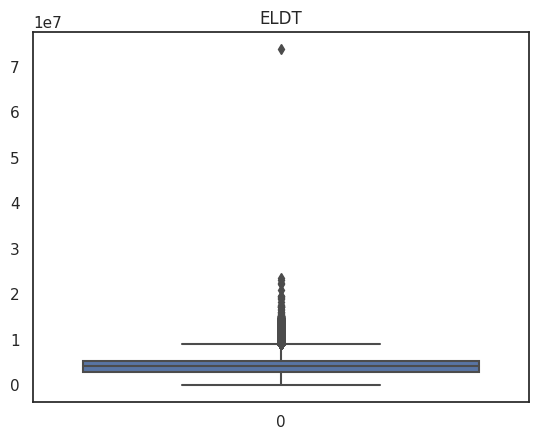

In [ ]:
# Boxplot do ELDT

sns.boxplot(BIMTRA_df_adjusted['eldt'], showfliers=True)

plt.title('ELDT')

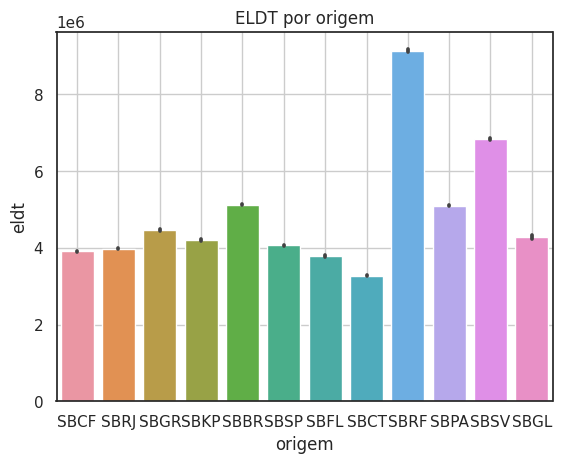

In [ ]:
sns.barplot(x=BIMTRA_df_adjusted['origem'], y=BIMTRA_df_adjusted['eldt'])

plt.title('ELDT por origem')
plt.grid(True)

plt.show()

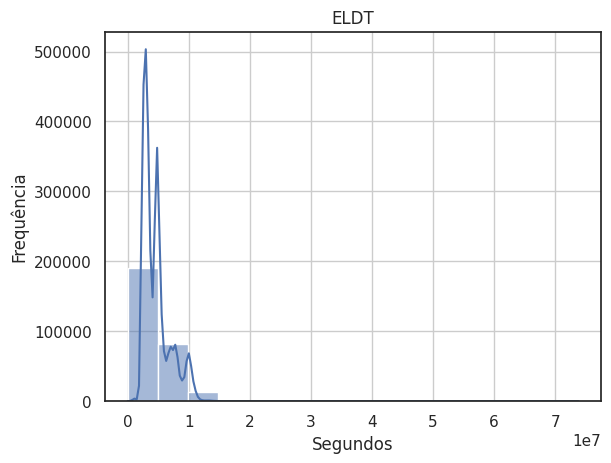

In [ ]:
sns.histplot(BIMTRA_df_adjusted['eldt'], bins=15, kde = True)

plt.xlabel('Segundos')
plt.ylabel('Frequência')
plt.title('ELDT')
plt.grid(True)

plt.show()

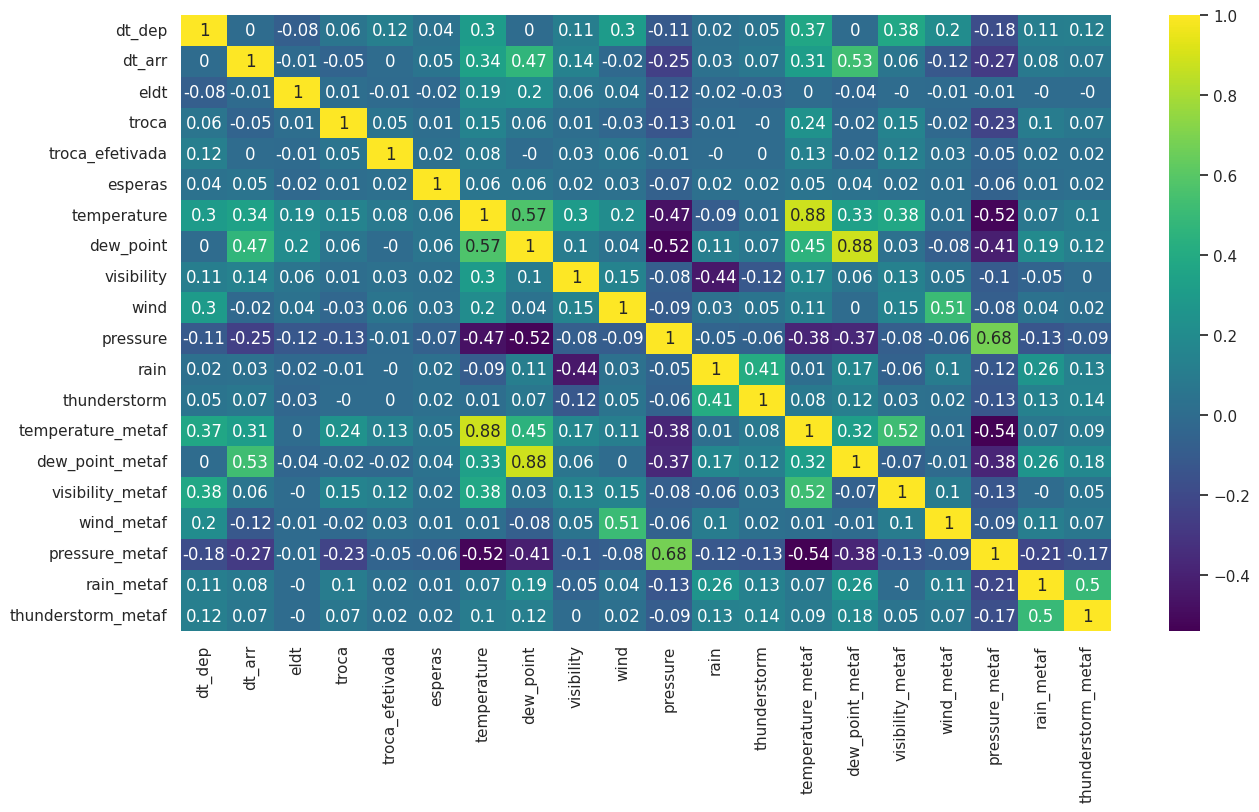

In [ ]:
# Correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(BIMTRA_df_adjusted.corr().round(2), cmap='viridis',annot=True)
plt.show()


In [ ]:
# Agrupar por origem e destino e calcular as estatísticas
impacto_aeroportos = BIMTRA_df_adjusted.groupby(['origem', 'destino']).agg({
    'flightid': 'count',              # Número total de voos
    'eldt': ['mean', 'min', 'max', 'std']  # Estatísticas de tempo de voo
}).reset_index()

# Renomear colunas para maior clareza
impacto_aeroportos.columns = ['Origem', 'Destino', 'Total_Voos', 'Tempo_Médio', 'Tempo_Mínimo', 'Tempo_Máximo', 'Desvio_Padrão']


display(impacto_aeroportos)

,Origem,Destino,Total_Voos,Tempo_Médio,Tempo_Mínimo,Tempo_Máximo,Desvio_Padrão
0,SBBR,SBCF,2992,3.298518e+06,1784000,6171000,284087.501994
1,SBBR,SBCT,1056,5.625054e+06,4999000,7148000,260428.622133
2,SBBR,SBFL,347,6.781703e+06,6020000,11724000,434887.250110
3,SBBR,SBGL,709,4.644795e+06,4043000,7165000,242529.296225
4,SBBR,SBGR,3530,4.671751e+06,3233000,15094000,374130.140507
...,...,...,...,...,...,...,...
133,SBSV,SBKP,1528,7.672034e+06,6563000,14055000,435601.958551
134,SBSV,SBPA,80,1.200070e+07,11010000,13671000,565408.498009
135,SBSV,SBRF,1671,3.815712e+06,3166000,9273000,447171.825250
136,SBSV,SBRJ,1850,6.789362e+06,4774000,16631000,511705.773859


# 3. Pré-processamento

In [ ]:
BIMTRA_df_adjusted

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,...,rain,thunderstorm,hora_metaf,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf
0,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,3638,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,052050016538ab736a254313ef009a6b,SBRJ,SBCF,33604,1654078210000,3006000,2022-06-01 09:00:00,2022-06-01 10:00:00,0.0,2022-06-01 09:00:00,...,0.0,0.0,2022-06-01 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,4845,1654051465000,5020000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0
3,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,4439,1654051301000,5262000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0
4,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,5198,1654051882000,5084000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,17.0,14.0,5000.0,14.0,1016.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,44059,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,...,0.0,0.0,2023-05-13 13:00:00,23.0,12.0,10000.0,4.0,1018.0,0.0,0.0
286620,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,34395,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,...,0.0,0.0,2023-05-13 10:00:00,17.0,12.0,10000.0,5.0,1016.0,0.0,0.0
286621,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,60833,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,...,0.0,0.0,2023-05-13 17:00:00,27.0,13.0,10000.0,2.0,1014.0,0.0,0.0
286622,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,19738,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,...,0.0,0.0,2023-05-13 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As colunas serão ordenadas. Colunas com alta correlação entre si podem ser descartadas. Além disso, apesar de manter aumentar os dados para o modelo analisar contribuirem com a diminuição do erro quadrático a primeiro momento, ao usar o modelo para prever os dados do kaggle foi observado que muitas colunas acabava tendo pior rendimento. Então, tentativa e erro pode ser um requisito?

In [ ]:
BIMTRA_df_encoded = BIMTRA_df_adjusted.copy()

# Organizando a ordem das colunas
coluna_esperas = BIMTRA_df_encoded.pop('esperas')  # Remove a coluna 'C' do DataFrame
BIMTRA_df_encoded.insert(4, 'esperas', coluna_esperas)  # Insere a coluna 'C' na posição desejada (posição 1 neste caso)

l = list(BIMTRA_df_encoded.columns)
l.remove('eldt')
l.remove('flightid')
l.remove('dt_arr')
#l.remove('dt_dep')
l.remove('hora_tcp')
l.remove('hora_tcr')
l.remove('hora_ref')
l.remove('hora_esperas')
l.remove('hora_metaf')
#l.remove('temperature')
#l.remove('dew_point')
#l.remove('wind')
#l.remove('pressure')
# l.remove('temperature_metaf')
# #l.remove('dew_point_metaf')
# l.remove('visibility_metaf')
# l.remove('wind_metaf')
# #l.remove('pressure_metaf')
# l.remove('troca')
# l.remove('troca_efetivada')
# #l.remove('visibility')
# #l.remove('esperas')
# #l.remove('rain')
# #l.remove('thunderstorm')
# l.remove('rain_metaf')
# l.remove('thunderstorm_metaf')
l.append('eldt')

BIMTRA_df_encoded = BIMTRA_df_encoded[l]

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
BIMTRA_df_encoded['origem'] = BIMTRA_df_encoded['origem'].astype('category')
BIMTRA_df_encoded['destino'] = BIMTRA_df_encoded['destino'].astype('category')

''' BIMTRA_df_encoded.rename(columns={'troca_efetivada': 'troca'}, inplace=True) '''


BIMTRA_df_encoded

,origem,destino,dt_dep,esperas,troca,troca_efetivada,temperature,dew_point,visibility,wind,...,rain,thunderstorm,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf,eldt
0,SBCF,SBFL,3638,0.0,0.0,0.0,21.0,14.0,10000.0,5.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5547000
1,SBRJ,SBCF,33604,0.0,0.0,0.0,22.0,21.0,12000.0,4.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3006000
2,SBGR,SBPA,4845,0.0,0.0,0.0,16.0,15.0,12000.0,3.0,...,0.0,0.0,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0,5020000
3,SBGR,SBPA,4439,0.0,0.0,0.0,16.0,15.0,12000.0,3.0,...,0.0,0.0,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0,5262000
4,SBKP,SBPA,5198,0.0,0.0,0.0,17.0,15.0,10000.0,14.0,...,0.0,0.0,17.0,14.0,5000.0,14.0,1016.0,0.0,0.0,5084000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,SBBR,SBRF,44059,0.0,0.0,0.0,21.0,14.0,10000.0,4.0,...,0.0,0.0,23.0,12.0,10000.0,4.0,1018.0,0.0,0.0,7564000
286620,SBBR,SBGR,34395,0.0,0.0,0.0,16.0,14.0,10000.0,0.0,...,0.0,0.0,17.0,12.0,10000.0,5.0,1016.0,0.0,0.0,5126000
286621,SBCF,SBRF,60833,0.0,0.0,0.0,26.0,14.0,12000.0,6.0,...,0.0,0.0,27.0,13.0,10000.0,2.0,1014.0,0.0,0.0,7591000
286622,SBSV,SBGR,19738,0.0,0.0,0.0,26.0,25.0,12000.0,3.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8743000


In [ ]:
# # Create a boolean mask to identify rows with blank values
# mask = BIMTRA_df_encoded.isnull().any(axis=1)

# # Use the mask to filter the DataFrame
# rows_with_blank_values = BIMTRA_df_encoded[mask]

# # Display the rows with blank values
# print(rows_with_blank_values)

# df = BIMTRA_df_encoded.dropna()

# 4. Treinamento 

A seguir vamos utilizar um algorítmo para encontrar as melhores métricas.

## Wrapper methods

Nos métodos wrapper, o processo de seleção de recursos é baseado em um algoritmo específico de aprendizado de máquina com o objetivo de ajustar as melhores variáveis para um determinado conjunto de dados.

Ele segue uma abordagem de greedy search, avaliando todas as combinações possíveis de recursos (features) em relação ao critério de avaliação. O critério de avaliação é a medida de desempenho que depende do tipo de problema, por ex: para o critério de avaliação de regressão podem ser valores p, R-quadrado, R-quadrado ajustado, da mesma forma para classificação o critério de avaliação pode ser acurácia, precisão, recall, pontuação f1, etc. 
Finalmente, ele seleciona a combinação de recursos que fornece os resultados ideais para o algoritmo de aprendizado de máquina especificado.

Forward selection: começamos com um modelo vazio e vamos adicionando variáveis.

Backward elimination: começamos com um modelo com todas as variáveis e vamos removendo as insignificantes estatisticamente.

Bi-directional elimination: é semelhante à forward selection, mas a diferença é que, ao adicionar um novo recurso, ele também verifica a importância dos recursos já adicionados e, se considerar insignificante algum dos recursos já selecionados, simplesmente remove esse recurso específico por meio da eliminação retroativa.

- k_features='best': Esse é o número máximo de características que o algoritmo tentará selecionar. No caso foi escolhido best para deixá-lo livre para escolher a quantidade que desejar

- forward e floating =

True & False = Forward selection 

False & False = Backward elimination

True & True= Bi-directional elimination

- verbose=2: Controla a saída de mensagens para o console durante a execução.

- scoring='neg_mean_squared_error': Usa o escore da média do erro quadrático para avaliar o desempenho do modelo.

- cv=scv: Usa a validação cruzada estratificada previamente configurada.

- n_jobs=-1: Usa todos os núcleos de CPU disponíveis para a computação paralela, se possível.

In [ ]:
# Mude para rodar essa célula ou não
otimizar_features = False

if otimizar_features == True:
    # Remover variaveis categoricas pois não são suportadas pelo algorítmo
    X = BIMTRA_df_encoded.drop(columns=['origem', 'destino'])
    X = X.copy().drop('eldt', axis=1)
    y = BIMTRA_df_encoded['eldt']

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42)

    scv = StratifiedKFold(n_splits=5)

    # SequentialFeatureSelector object
    sfs = SequentialFeatureSelector(xg.XGBRegressor(objective='reg:squarederror',
                                                    enable_categorical=True), 
                                    k_features='best',
                                    forward=False, 
                                    floating=False,
                                    verbose=2,           
                                    scoring='neg_mean_squared_error',
                                    cv=0)


    # Ajustar o objeto aos dados de treinamento
    sfs = sfs.fit(X_train, y_train)

    # Salvar variáveis escolhidas
    selected_features = list(X_train.columns[list(sfs.k_feature_idx_)])
    print("Variáveis selecionados:", selected_features)
else:
    # Estas foram os features selecionados pelos diferentes algoritmos
    # Forward selection
    selected_features = ['dt_dep', 'esperas', 'troca', 'troca_efetivada', 'temperature', 'dew_point', 'visibility', 'wind', 'pressure', 'thunderstorm', 'temperature_metaf']
    # Bi-directional elimination
    selected_features = ['dt_dep', 'esperas', 'troca', 'troca_efetivada', 'temperature', 'dew_point', 'visibility', 'wind', 'pressure', 'rain', 'thunderstorm', 'temperature_metaf', 'dew_point_metaf', 'wind_metaf']


Agora usamos estes features para treinar o modelo.

In [ ]:
# Constrindo modelo completo com features selecionados
selected_features = ['origem', 'destino'] + selected_features

X = BIMTRA_df_adjusted[selected_features]
y = BIMTRA_df_adjusted['eldt']

X['origem'] = X['origem'].astype('category')
X['destino'] = X['destino'].astype('category')



/tmp/ipykernel_935/1738605412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['origem'] = X['origem'].astype('category')
/tmp/ipykernel_935/1738605412.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['destino'] = X['destino'].astype('category')


Infelizmente estamos tendo pontuacao ruim com essas featues no kaggle, entao vamos selecionar na mao mesmo.

In [ ]:
l = list(X.columns)

# l.remove('troca')
# l.remove('troca_efetivada')
# l.remove('thunderstorm')
# l.remove('temperature')
# l.remove('dew_point')
# l.remove('temperature_metaf')
X = X[l]

selected_features = l

## Treinamento

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
reg = xg.XGBRegressor(
    objective='reg:squarederror',
    enable_categorical=True,
)

reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 4.1 Performance do modelo

In [ ]:
print("Performance do modelo nos dados de treino: ", str(round(reg.score(X_train, y_train) * 100, 2))+"%")
print("Performance do modelo nos dados de teste: ", str(round(reg.score(X_test, y_test) * 100, 2))+"%")

Performance do modelo nos dados de treino:  97.21%
Performance do modelo nos dados de teste:  96.68%


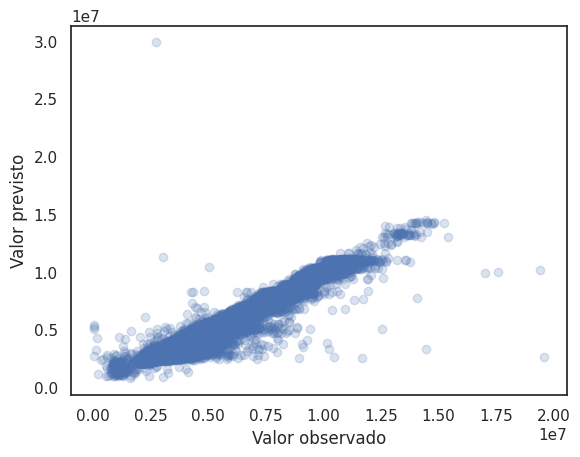

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

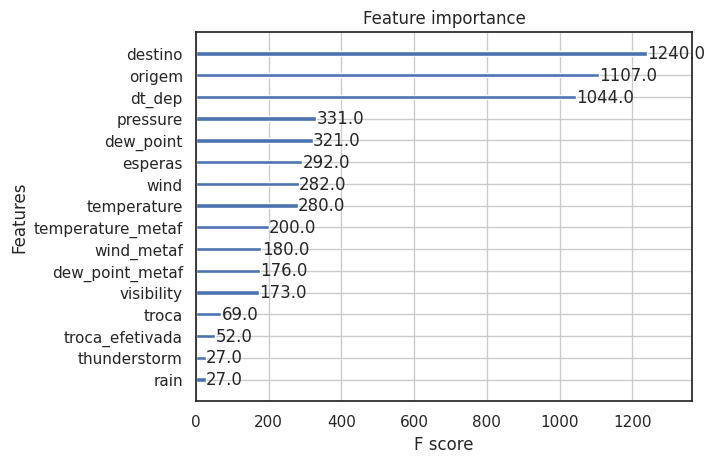

In [ ]:
# Previsão
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Valor observado')
plt.ylabel('Valor previsto')
plt.show()

xg.plot_importance(reg)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Erro Quadrático Médio (MSE): ", mean_squared_error(y_test, y_pred))
print("Erro Absoluto Médio (MAE): ", mean_absolute_error(y_test, y_pred))
print("Raiz do Erro Quadrático Médio (RMSE) : ", np.sqrt(mean_squared_error(y_test, y_pred)))

print("R2: ", r2_score(y_test, y_pred))

Erro Quadrático Médio (MSE):  162916591987.48322
Erro Absoluto Médio (MAE):  234310.35121020497
Raiz do Erro Quadrático Médio (RMSE) :  403629.275434133
R2:  0.9668092616137752


## Escolhendo features novamente

In [ ]:
X_train_features = X_train.drop(columns=['origem', 'destino'])

In [ ]:
selector = SelectFromModel(estimator=reg)
selector.fit(X_train_features, y_train)

selected_feature_indices = selector.get_support(indices=True)

for i, col in enumerate(X.columns):
    print(f"{col} selected={i in selected_feature_indices}")

origem selected=True
destino selected=False
dt_dep selected=False
esperas selected=False
troca selected=True
troca_efetivada selected=True
temperature selected=False
dew_point selected=False
visibility selected=False
wind selected=False
pressure selected=False
rain selected=False
thunderstorm selected=False
temperature_metaf selected=True
dew_point_metaf selected=False
wind_metaf selected=False


In [ ]:

rfe = RFE(estimator=reg)
rfe.fit(X_train_features, y_train)
selected_features = []
for i, col in zip(range(X_train_features.shape[1]), X_train_features.columns):
    print(f"{col} selected={rfe.support_[i]} rank={rfe.ranking_[i]}")
    if rfe.support_[i]==True:
        selected_features.append(col)

dt_dep selected=True rank=1
esperas selected=False rank=3
troca selected=False rank=8
troca_efetivada selected=False rank=7
temperature selected=True rank=1
dew_point selected=True rank=1
visibility selected=True rank=1
wind selected=False rank=2
pressure selected=True rank=1
rain selected=False rank=4
thunderstorm selected=False rank=5
temperature_metaf selected=True rank=1
dew_point_metaf selected=False rank=6
wind_metaf selected=True rank=1


In [ ]:
selected_features = ['origem', 'destino'] + selected_features

## Randomized search

Script para encontrar os melhores parâmetros para o XGBoost baseado no randomized search.

In [ ]:
otimizar_regressor = False

if otimizar_regressor == True:
    reg = xg.XGBRegressor(objective= 'reg:squarederror', random_state=42, enable_categorical=True)

    # Busca de melhores parâmetros 
    params = {
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 0.5),
        "learning_rate": uniform(0.03, 0.3), # default 0.1 
        "max_depth": randint(2, 6), # default 3
        "n_estimators": randint(100, 150), # default 100
        "subsample": uniform(0.6, 0.4)
    }

    search = RandomizedSearchCV(reg, param_distributions=params, random_state=42, n_iter=100, cv=3, verbose=2, n_jobs=1, return_train_score=True)

    search.fit(X_train, y_train)

    def report_best_scores(results, n_top=3):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results['mean_test_score'][candidate],
                    results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")

    report_best_scores(search.cv_results_, 1)

In [ ]:
# reg = xg.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7467983561008608, gamma=0.02904180608409973, learning_rate=0.28985284373248055, max_depth=5, n_estimators=139, subsample=0.8832290311184181, random_state=42, early_stopping_rounds=10, eval_set=[(X_test, y_test)], enable_categorical=True)

# Valores para esperas, pressao, visibilidade e velocidade do vento
# objective='reg:squarederror',
# colsample_bytree= 0.935552788417904,
# gamma= 0.09983689107917987, 
# learning_rate= 0.18427033152408348, 
# max_depth= 5, 
# n_estimators= 102, 
# subsample= 0.9439761626945282,
# random_state = 42,
# enable_categorical=True,




## Treinamento final

In [ ]:
selected_features = ['origem',
 'destino',
 'dt_dep',
 'esperas',
 'thunderstorm',
 'pressure',
 'dew_point_metaf',
 'wind_metaf']

In [ ]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
reg = xg.XGBRegressor(
    objective='reg:squarederror',
    enable_categorical=True,
)

reg.fit(X_train_selected, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 4.1 Performance do modelo

In [ ]:
print("Performance do modelo nos dados de treino: ", str(round(reg.score(X_train_selected, y_train) * 100, 2))+"%")
print("Performance do modelo nos dados de teste: ", str(round(reg.score(X_test_selected, y_test) * 100, 2))+"%")

Performance do modelo nos dados de treino:  97.03%
Performance do modelo nos dados de teste:  96.74%


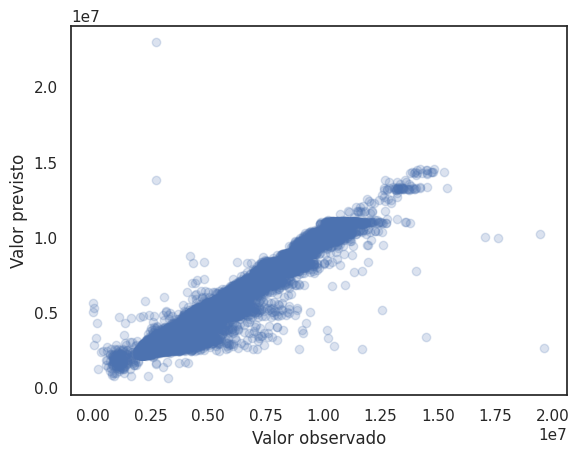

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

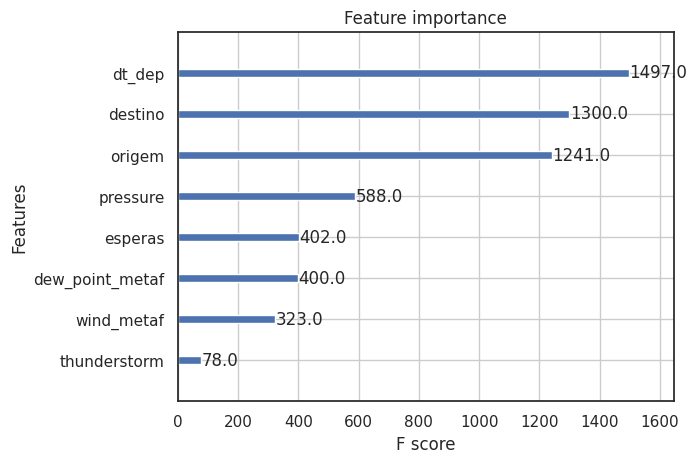

In [ ]:
# Previsão
y_pred = reg.predict(X_test_selected)

plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Valor observado')
plt.ylabel('Valor previsto')
plt.show()

xg.plot_importance(reg)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Erro Quadrático Médio (MSE): ", mean_squared_error(y_test, y_pred))
print("Erro Absoluto Médio (MAE): ", mean_absolute_error(y_test, y_pred))
print("Raiz do Erro Quadrático Médio (RMSE) : ", np.sqrt(mean_squared_error(y_test, y_pred)))

print("R2: ", r2_score(y_test, y_pred))

Erro Quadrático Médio (MSE):  159814906116.38217
Erro Absoluto Médio (MAE):  236139.59925425207
Raiz do Erro Quadrático Médio (RMSE) :  399768.5656931797
R2:  0.9674411631472414


# 5. Submissão

In [ ]:
# Csv de teste do Kaggle
idsc_test = pd.read_csv('idsc_dataset.csv', sep=';')
idsc_test

,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,4f0356600f61e3fcbea8ed8a137a2423,SBBR,SBSP,11:00:00,11:53:30,MULTIPOINT ((-0.9862962481402141 -0.2329259019...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,1,SBSP,...,METAF SBSP 211100Z 32007KT 9999 SCT033 ...,SBSP,10:00:00,METAR SBSP 211000Z 34007KT 290V010 CAVOK 18/13...,SBSP,11:00:00,0.0,SBSP,NaN,NaN
1,865dbbbe74bebea18a71f24342516ff0,SBSP,SBCT,00:00:00,00:04:37,MULTIPOINT ((-0.8863534722346053 -0.5093356150...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBCT,...,METAF SBCT 150000Z 11008KT 1000 BR OVC033...,SBCT,23:00:00,METAR SBCT 142300Z 13005KT 100V200 CAVOK 11/06...,SBCT,00:00:00,0.0,SBCT,23:00:00,SBCT
2,1803af9cfc6a2c74d188481e3ffd848e,SBGR,SBPA,01:00:00,01:33:15,MULTIPOINT ((-0.8966138193125871 -0.5115119601...,http://satelite.cptec.inpe.br/repositoriogoes/...,00:00:00,0,SBPA,...,METAF SBPA 030100Z 08005KT 9999 SCT011 ...,SBPA,00:00:00,METAR SBPA 030000Z 07004KT 030V090 9000 NSC 21...,SBPA,01:00:00,0.0,SBPA,NaN,NaN
3,f6af733a687f904183efd149ec713be5,SBCT,SBSV,03:00:00,03:54:14,MULTIPOINT ((-0.8586718860112791 -0.4418648049...,http://satelite.cptec.inpe.br/repositoriogoes/...,02:00:00,0,SBSV,...,NaN,NaN,02:00:00,METAR SBSV 150200Z 06009KT 9999 SCT020 25/22 Q...,SBSV,03:00:00,0.0,SBSV,02:00:00,SBSV
4,6117f9ac60b7f66b740c9130be433313,SBRJ,SBGR,00:00:00,00:27:32,MULTIPOINT ((-0.8914635585346382 -0.5234904405...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBGR,...,METAF SBGR 230000Z 32008KT CAVOK 24/04 Q1010=\n,SBGR,23:00:00,METAR COR SBGR 222300Z 06004KT CAVOK 23/08 Q1013=,SBGR,00:00:00,0.0,SBGR,23:00:00,SBGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40034,4e08052066073297c7a3c55798618324,SBSV,SBRF,20:00:00,20:25:00,MULTIPOINT ((-0.8955415064673201 -0.5234137952...,http://satelite.cptec.inpe.br/repositoriogoes/...,19:00:00,0,SBRF,...,NaN,NaN,19:00:00,METAR SBRF 181900Z 19015KT 9999 SCT023 BKN060 ...,SBRF,20:00:00,0.0,SBRF,NaN,NaN
40035,e22f120c65f5759aa8df576b59d71be3,SBCT,SBSP,08:00:00,08:50:22,MULTIPOINT ((-0.8903194203987348 -0.5144905777...,http://satelite.cptec.inpe.br/repositoriogoes/...,07:00:00,0,SBSP,...,METAF SBSP 090800Z 36003KT CAVOK 19/10 Q1017=\n,SBSP,07:00:00,METAR SBSP 090700Z AUTO VRB02KT CAVOK 19/17 Q1...,SBSP,08:00:00,0.0,SBSP,NaN,NaN
40036,ca9399162037201a4d0c49c832a32739,SBGR,SBCF,11:00:00,11:30:03,MULTIPOINT ((-0.8963144777278773 -0.5234059876...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,0,SBCF,...,METAF SBCF 221100Z 13004KT CAVOK 21/09 Q1016=\n,SBCF,10:00:00,METAR SBCF 221000Z 16003KT 9000 NSC 13/12 Q1018=,SBCF,11:00:00,0.0,SBCF,NaN,NaN
40037,560136088f5f1493dbad809a3554172c,SBBR,SBGR,12:00:00,12:25:21,NaN,http://satelite.cptec.inpe.br/repositoriogoes/...,11:00:00,0,SBGR,...,METAF SBGR 231200Z 34010KT CAVOK 25/07 Q1012=\n,SBGR,11:00:00,METAR SBGR 231100Z 03004KT CAVOK 25/10 Q1014=,SBGR,12:00:00,0.0,SBGR,NaN,NaN


Tratar dados dt_dep

In [ ]:
idsc_test['dt_dep'] = idsc_test['dt_dep'].apply(hours_to_seconds)

Tratar dados cabeceiras

In [ ]:
idsc_test.rename(columns={'aero_tcr': 'troca_efetivada'}, inplace=True)
idsc_test['troca_efetivada'] = idsc_test['troca_efetivada'].apply(lambda x: 0 if pd.isna(x) else 1)
idsc_test


,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,troca_efetivada
0,4f0356600f61e3fcbea8ed8a137a2423,SBBR,SBSP,11:00:00,42810,MULTIPOINT ((-0.9862962481402141 -0.2329259019...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,1,SBSP,...,METAF SBSP 211100Z 32007KT 9999 SCT033 ...,SBSP,10:00:00,METAR SBSP 211000Z 34007KT 290V010 CAVOK 18/13...,SBSP,11:00:00,0.0,SBSP,NaN,0
1,865dbbbe74bebea18a71f24342516ff0,SBSP,SBCT,00:00:00,277,MULTIPOINT ((-0.8863534722346053 -0.5093356150...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBCT,...,METAF SBCT 150000Z 11008KT 1000 BR OVC033...,SBCT,23:00:00,METAR SBCT 142300Z 13005KT 100V200 CAVOK 11/06...,SBCT,00:00:00,0.0,SBCT,23:00:00,1
2,1803af9cfc6a2c74d188481e3ffd848e,SBGR,SBPA,01:00:00,5595,MULTIPOINT ((-0.8966138193125871 -0.5115119601...,http://satelite.cptec.inpe.br/repositoriogoes/...,00:00:00,0,SBPA,...,METAF SBPA 030100Z 08005KT 9999 SCT011 ...,SBPA,00:00:00,METAR SBPA 030000Z 07004KT 030V090 9000 NSC 21...,SBPA,01:00:00,0.0,SBPA,NaN,0
3,f6af733a687f904183efd149ec713be5,SBCT,SBSV,03:00:00,14054,MULTIPOINT ((-0.8586718860112791 -0.4418648049...,http://satelite.cptec.inpe.br/repositoriogoes/...,02:00:00,0,SBSV,...,NaN,NaN,02:00:00,METAR SBSV 150200Z 06009KT 9999 SCT020 25/22 Q...,SBSV,03:00:00,0.0,SBSV,02:00:00,1
4,6117f9ac60b7f66b740c9130be433313,SBRJ,SBGR,00:00:00,1652,MULTIPOINT ((-0.8914635585346382 -0.5234904405...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBGR,...,METAF SBGR 230000Z 32008KT CAVOK 24/04 Q1010=\n,SBGR,23:00:00,METAR COR SBGR 222300Z 06004KT CAVOK 23/08 Q1013=,SBGR,00:00:00,0.0,SBGR,23:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40034,4e08052066073297c7a3c55798618324,SBSV,SBRF,20:00:00,73500,MULTIPOINT ((-0.8955415064673201 -0.5234137952...,http://satelite.cptec.inpe.br/repositoriogoes/...,19:00:00,0,SBRF,...,NaN,NaN,19:00:00,METAR SBRF 181900Z 19015KT 9999 SCT023 BKN060 ...,SBRF,20:00:00,0.0,SBRF,NaN,0
40035,e22f120c65f5759aa8df576b59d71be3,SBCT,SBSP,08:00:00,31822,MULTIPOINT ((-0.8903194203987348 -0.5144905777...,http://satelite.cptec.inpe.br/repositoriogoes/...,07:00:00,0,SBSP,...,METAF SBSP 090800Z 36003KT CAVOK 19/10 Q1017=\n,SBSP,07:00:00,METAR SBSP 090700Z AUTO VRB02KT CAVOK 19/17 Q1...,SBSP,08:00:00,0.0,SBSP,NaN,0
40036,ca9399162037201a4d0c49c832a32739,SBGR,SBCF,11:00:00,41403,MULTIPOINT ((-0.8963144777278773 -0.5234059876...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,0,SBCF,...,METAF SBCF 221100Z 13004KT CAVOK 21/09 Q1016=\n,SBCF,10:00:00,METAR SBCF 221000Z 16003KT 9000 NSC 13/12 Q1018=,SBCF,11:00:00,0.0,SBCF,NaN,0
40037,560136088f5f1493dbad809a3554172c,SBBR,SBGR,12:00:00,44721,NaN,http://satelite.cptec.inpe.br/repositoriogoes/...,11:00:00,0,SBGR,...,METAF SBGR 231200Z 34010KT CAVOK 25/07 Q1012=\n,SBGR,11:00:00,METAR SBGR 231100Z 03004KT CAVOK 25/10 Q1014=,SBGR,12:00:00,0.0,SBGR,NaN,0


Tratar dados metar

In [ ]:
if os.path.exists('metar_columns_submission.csv'):
    # Se o arquivo existe, leia-o para um DataFrame
    metar_columns_sub = pd.read_csv('metar_columns_submission.csv')
    if "Unnamed: 0" in metar_columns_sub.columns:
        metar_columns_sub = metar_columns_sub.drop(columns=["Unnamed: 0"])
else:
    metar_columns_sub = get_all_metar_data(idsc_test['metar'])
    metar_columns_sub.to_csv('metar_columns_submission.csv')

metar_columns_sub


,aeroporto,report_type,time,temperature,dew_point,visibility,wind,visual_range,pressure,weather,sky
0,SBSP,NaN,Thu Sep 21 10:00:00 2023,18.0 C,13.0 C,10000 meters,WNW to N at 7 knots,NaN,1016.0 mb,NaN,NaN
1,SBCT,NaN,Thu Sep 14 23:00:00 2023,11.0 C,6.0 C,10000 meters,E to SSW at 5 knots,NaN,1020.0 mb,NaN,NaN
2,SBPA,NaN,Tue Oct 3 00:00:00 2023,21.0 C,18.0 C,9000 meters,NNE to E at 4 knots,NaN,1009.0 mb,NaN,clear
3,SBSV,NaN,Fri Sep 15 02:00:00 2023,25.0 C,22.0 C,greater than 10000 meters,ENE at 9 knots,NaN,1016.0 mb,NaN,scattered clouds at 2000 feet
4,SBGR,NaN,Fri Sep 22 23:00:00 2023,23.0 C,8.0 C,10000 meters,ENE at 4 knots,NaN,1013.0 mb,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
40034,SBRF,NaN,Mon Sep 18 19:00:00 2023,27.0 C,22.0 C,greater than 10000 meters,S at 15 knots,NaN,1013.0 mb,NaN,scattered clouds at 2300 feet\n broken clo...
40035,SBSP,NaN,Sat Sep 9 07:00:00 2023,19.0 C,17.0 C,10000 meters,variable at 2 knots,NaN,1019.0 mb,NaN,NaN
40036,SBCF,NaN,Fri Sep 22 10:00:00 2023,13.0 C,12.0 C,9000 meters,SSE at 3 knots,NaN,1018.0 mb,NaN,clear
40037,SBGR,NaN,Sat Sep 23 11:00:00 2023,25.0 C,10.0 C,10000 meters,NNE at 4 knots,NaN,1014.0 mb,NaN,NaN


In [ ]:
metar_to_merge_sub = get_columns_metar(metar_columns_sub)

metar_to_merge_sub

,temperature,dew_point,visibility,wind,pressure,rain,thunderstorm
0,18.0,13.0,10000.0,7.0,1016.0,0,0
1,11.0,6.0,10000.0,5.0,1020.0,0,0
2,21.0,18.0,9000.0,4.0,1009.0,0,0
3,25.0,22.0,12000.0,9.0,1016.0,0,0
4,23.0,8.0,10000.0,4.0,1013.0,0,0
...,...,...,...,...,...,...,...
40034,27.0,22.0,12000.0,15.0,1013.0,0,0
40035,19.0,17.0,10000.0,2.0,1019.0,0,0
40036,13.0,12.0,9000.0,3.0,1018.0,0,0
40037,25.0,10.0,10000.0,4.0,1014.0,0,0


In [ ]:
idsc_test = pd.concat([idsc_test, metar_to_merge_sub], axis=1)

Tratar dados metaf

In [ ]:
idsc_test['metaf'] = idsc_test['metaf'].str.replace('METAF', 'METAR')

if os.path.exists('metaf_columns_submission.csv'):
    # Se o arquivo existe, leia-o para um DataFrame
    metaf_columns_sub = pd.read_csv('metaf_columns_submission.csv')
    if "Unnamed: 0" in metaf_columns_sub.columns:
        metaf_columns_sub = metaf_columns_sub.drop(columns=["Unnamed: 0"])
else:
    metaf_columns_sub = get_all_metar_data(idsc_test['metaf'])
    metaf_columns_sub.to_csv('metaf_columns_submission.csv')


metaf_columns_sub

,aeroporto,report_type,time,temperature,dew_point,visibility,wind,visual_range,pressure,weather,sky
0,SBSP,NaN,Thu Sep 21 11:00:00 2023,18.0 C,13.0 C,greater than 10000 meters,NW at 7 knots,NaN,1014.0 mb,NaN,scattered clouds at 3300 feet
1,SBCT,NaN,Fri Sep 15 00:00:00 2023,11.0 C,10.0 C,1000 meters,ESE at 8 knots,NaN,1020.0 mb,mist,overcast at 3300 feet
2,SBPA,NaN,Tue Oct 3 01:00:00 2023,21.0 C,16.0 C,greater than 10000 meters,E at 5 knots,NaN,1010.0 mb,NaN,scattered clouds at 1100 feet
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SBGR,NaN,Sat Sep 23 00:00:00 2023,24.0 C,4.0 C,10000 meters,NW at 8 knots,NaN,1010.0 mb,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
40034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40035,SBSP,NaN,Sat Sep 9 08:00:00 2023,19.0 C,10.0 C,10000 meters,N at 3 knots,NaN,1017.0 mb,NaN,NaN
40036,SBCF,NaN,Fri Sep 22 11:00:00 2023,21.0 C,9.0 C,10000 meters,SE at 4 knots,NaN,1016.0 mb,NaN,NaN
40037,SBGR,NaN,Sat Sep 23 12:00:00 2023,25.0 C,7.0 C,10000 meters,NNW at 10 knots,NaN,1012.0 mb,NaN,NaN


In [ ]:
# Todos os erros do dataset foram bem tratados, logo a quantidade de nulos é igual
comparacao = idsc_test['metaf'].isnull() == metaf_columns_sub['aeroporto'].isnull()

# Número diferente de nulos tem q ser 0
print(comparacao[comparacao == False])

Series([], dtype: bool)


In [ ]:
metaf_to_merge_sub = metaf_columns_sub.copy()

metaf_to_merge_sub = get_columns_metar(metaf_to_merge_sub)
metaf_to_merge_sub.columns = change_columns_names_metaf(metaf_to_merge_sub)
idsc_test = pd.concat([idsc_test, metaf_to_merge_sub], axis=1)

metaf_to_merge_sub

,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf
0,18.0,13.0,12000.0,7.0,1014.0,0,0
1,11.0,10.0,1000.0,8.0,1020.0,0,0
2,21.0,16.0,12000.0,5.0,1010.0,0,0
3,NaN,NaN,NaN,NaN,NaN,0,0
4,24.0,4.0,10000.0,8.0,1010.0,0,0
...,...,...,...,...,...,...,...
40034,NaN,NaN,NaN,NaN,NaN,0,0
40035,19.0,10.0,10000.0,3.0,1017.0,0,0
40036,21.0,9.0,10000.0,4.0,1016.0,0,0
40037,25.0,7.0,10000.0,10.0,1012.0,0,0


In [ ]:
idsc_test_encoded = idsc_test.copy()

# Organizando as colunas
colunas_sub = selected_features.copy()
idsc_test_encoded = idsc_test_encoded[colunas_sub]

# Converte data e hora para o tipo milissegundos desde 1970
datetime_to_int64(idsc_test_encoded, 'dt_dep')

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
idsc_test_encoded['origem'] = idsc_test_encoded['origem'].astype('category')
idsc_test_encoded['destino'] = idsc_test_encoded['destino'].astype('category')

idsc_test_encoded

,origem,destino,dt_dep,esperas,thunderstorm,pressure,dew_point_metaf,wind_metaf
0,SBBR,SBSP,0.042810,1,0,1016.0,13.0,7.0
1,SBSP,SBCT,0.000277,0,0,1020.0,10.0,8.0
2,SBGR,SBPA,0.005595,0,0,1009.0,16.0,5.0
3,SBCT,SBSV,0.014054,0,0,1016.0,NaN,NaN
4,SBRJ,SBGR,0.001652,0,0,1013.0,4.0,8.0
...,...,...,...,...,...,...,...,...
40034,SBSV,SBRF,0.073500,0,0,1013.0,NaN,NaN
40035,SBCT,SBSP,0.031822,0,0,1019.0,10.0,3.0
40036,SBGR,SBCF,0.041403,0,0,1018.0,9.0,4.0
40037,SBBR,SBGR,0.044721,0,0,1014.0,7.0,10.0


In [ ]:
idsc_test_encoded['origem']

0        SBBR
1        SBSP
2        SBGR
3        SBCT
4        SBRJ
         ... 
40034    SBSV
40035    SBCT
40036    SBGR
40037    SBBR
40038    SBGR
Name: origem, Length: 40039, dtype: category
Categories (12, object): ['SBBR', 'SBCF', 'SBCT', 'SBFL', ..., 'SBRF', 'SBRJ', 'SBSP', 'SBSV']

In [ ]:
# Prediz os valores
y_pred = reg.predict(idsc_test_encoded)
data_in_seconds = y_pred / 1000.0

# Colocar 0 onde a origem e destino são iguais (erro da competição)
for indice, linha in idsc_test_encoded.iterrows():
    # Verifique se os aeroportos de origem e destino são iguais
    if linha['origem'] == linha['destino']:
        # Defina o ELDT como 0 nas previsões
        data_in_seconds[indice] = 0

# Criar um DataFrame com a coluna de dados em segundos
y_pred = pd.DataFrame(data_in_seconds)

y_pred

,0
0,5113.921875
1,2459.362793
2,6723.391113
3,8912.481445
4,2766.740723
...,...
40034,3663.018555
40035,2842.697510
40036,2966.748779
40037,4743.302734


In [ ]:
sumbission = pd.DataFrame()
sumbission['ID'] = idsc_test['flightid']
sumbission['solution'] = y_pred

sumbission.to_csv('submission.csv', index=False)

In [ ]:
sumbission

,ID,solution
0,4f0356600f61e3fcbea8ed8a137a2423,5113.921875
1,865dbbbe74bebea18a71f24342516ff0,2459.362793
2,1803af9cfc6a2c74d188481e3ffd848e,6723.391113
3,f6af733a687f904183efd149ec713be5,8912.481445
4,6117f9ac60b7f66b740c9130be433313,2766.740723
...,...,...
40034,4e08052066073297c7a3c55798618324,3663.018555
40035,e22f120c65f5759aa8df576b59d71be3,2842.697510
40036,ca9399162037201a4d0c49c832a32739,2966.748779
40037,560136088f5f1493dbad809a3554172c,4743.302734


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4ef28bfa-f18c-417e-93b5-8e27cf9bc92e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>